# TM10007 Assignment template -- ECG data

## Imports

In [12]:
import zipfile
import os
import pandas as pd
import numpy as np
import time

from statistics import median
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,  average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier



## Data loading

Load the dataset

In [13]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


## Outer cross-validation
Split data set intro training and test set

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Univariatiate statistical feature selection performed: 569 features selected.
PCA feature selection performed: 71 features left.
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for SGDClassifier: {'alpha': 0.001, 'loss': 'log_loss', 'penalty': 'l2'}
Best parameters for KNeighborsClassifier: {'n_neighbors': 7, 'weights': 'uniform'}
Best parameters for DecisionTreeClassifier: {'max_depth': 9, 'min_samples_split': 2}
Best parameters for SVC: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}
Best parameters for RandomForestClassifier: {'max_depth': 3, 'n_estimators': 50}
Best parameters for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for SGDClassifier: {'alpha': 0.001, 'loss': 'log_loss', 'penalty': 'l2'}
Best parameters for KNeighborsClassifier: {'n_neighbors': 3, 'weights': 'uniform'}
Best parameters for DecisionTreeClassifier: {'max_depth': 7, 'min_samples_split': 2}
Best parameters for SVC: {'

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Univariatiate statistical feature selection performed: 1754 features selected.
PCA feature selection performed: 99 features left.
Best parameters for LogisticRegression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for SGDClassifier: {'alpha': 0.1, 'loss': 'hinge', 'penalty': 'l2'}
Best parameters for KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'}
Best parameters for DecisionTreeClassifier: {'max_depth': 3, 'min_samples_split': 2}
Best parameters for SVC: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}
Best parameters for RandomForestClassifier: {'max_depth': 3, 'n_estimators': 10}
Best parameters for LogisticRegression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for SGDClassifier: {'alpha': 0.1, 'loss': 'hinge', 'penalty': 'l2'}
Best parameters for KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'}
Best parameters for DecisionTreeClassifier: {'max_depth': 9, 'min_samples_split': 5}
Best parameters for SVC: {'C': 0.1

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Univariatiate statistical feature selection performed: 733 features selected.
PCA feature selection performed: 59 features left.
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for SGDClassifier: {'alpha': 0.001, 'loss': 'log_loss', 'penalty': 'l2'}
Best parameters for KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'}
Best parameters for DecisionTreeClassifier: {'max_depth': 11, 'min_samples_split': 10}
Best parameters for SVC: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}
Best parameters for RandomForestClassifier: {'max_depth': 3, 'n_estimators': 10}
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for SGDClassifier: {'alpha': 0.001, 'loss': 'modified_huber', 'penalty': 'l1'}
Best parameters for KNeighborsClassifier: {'n_neighbors': 7, 'weights': 'uniform'}
Best parameters for DecisionTreeClassifier: {'max_depth': 9, 'min_samples_split': 2}
Best parameters 

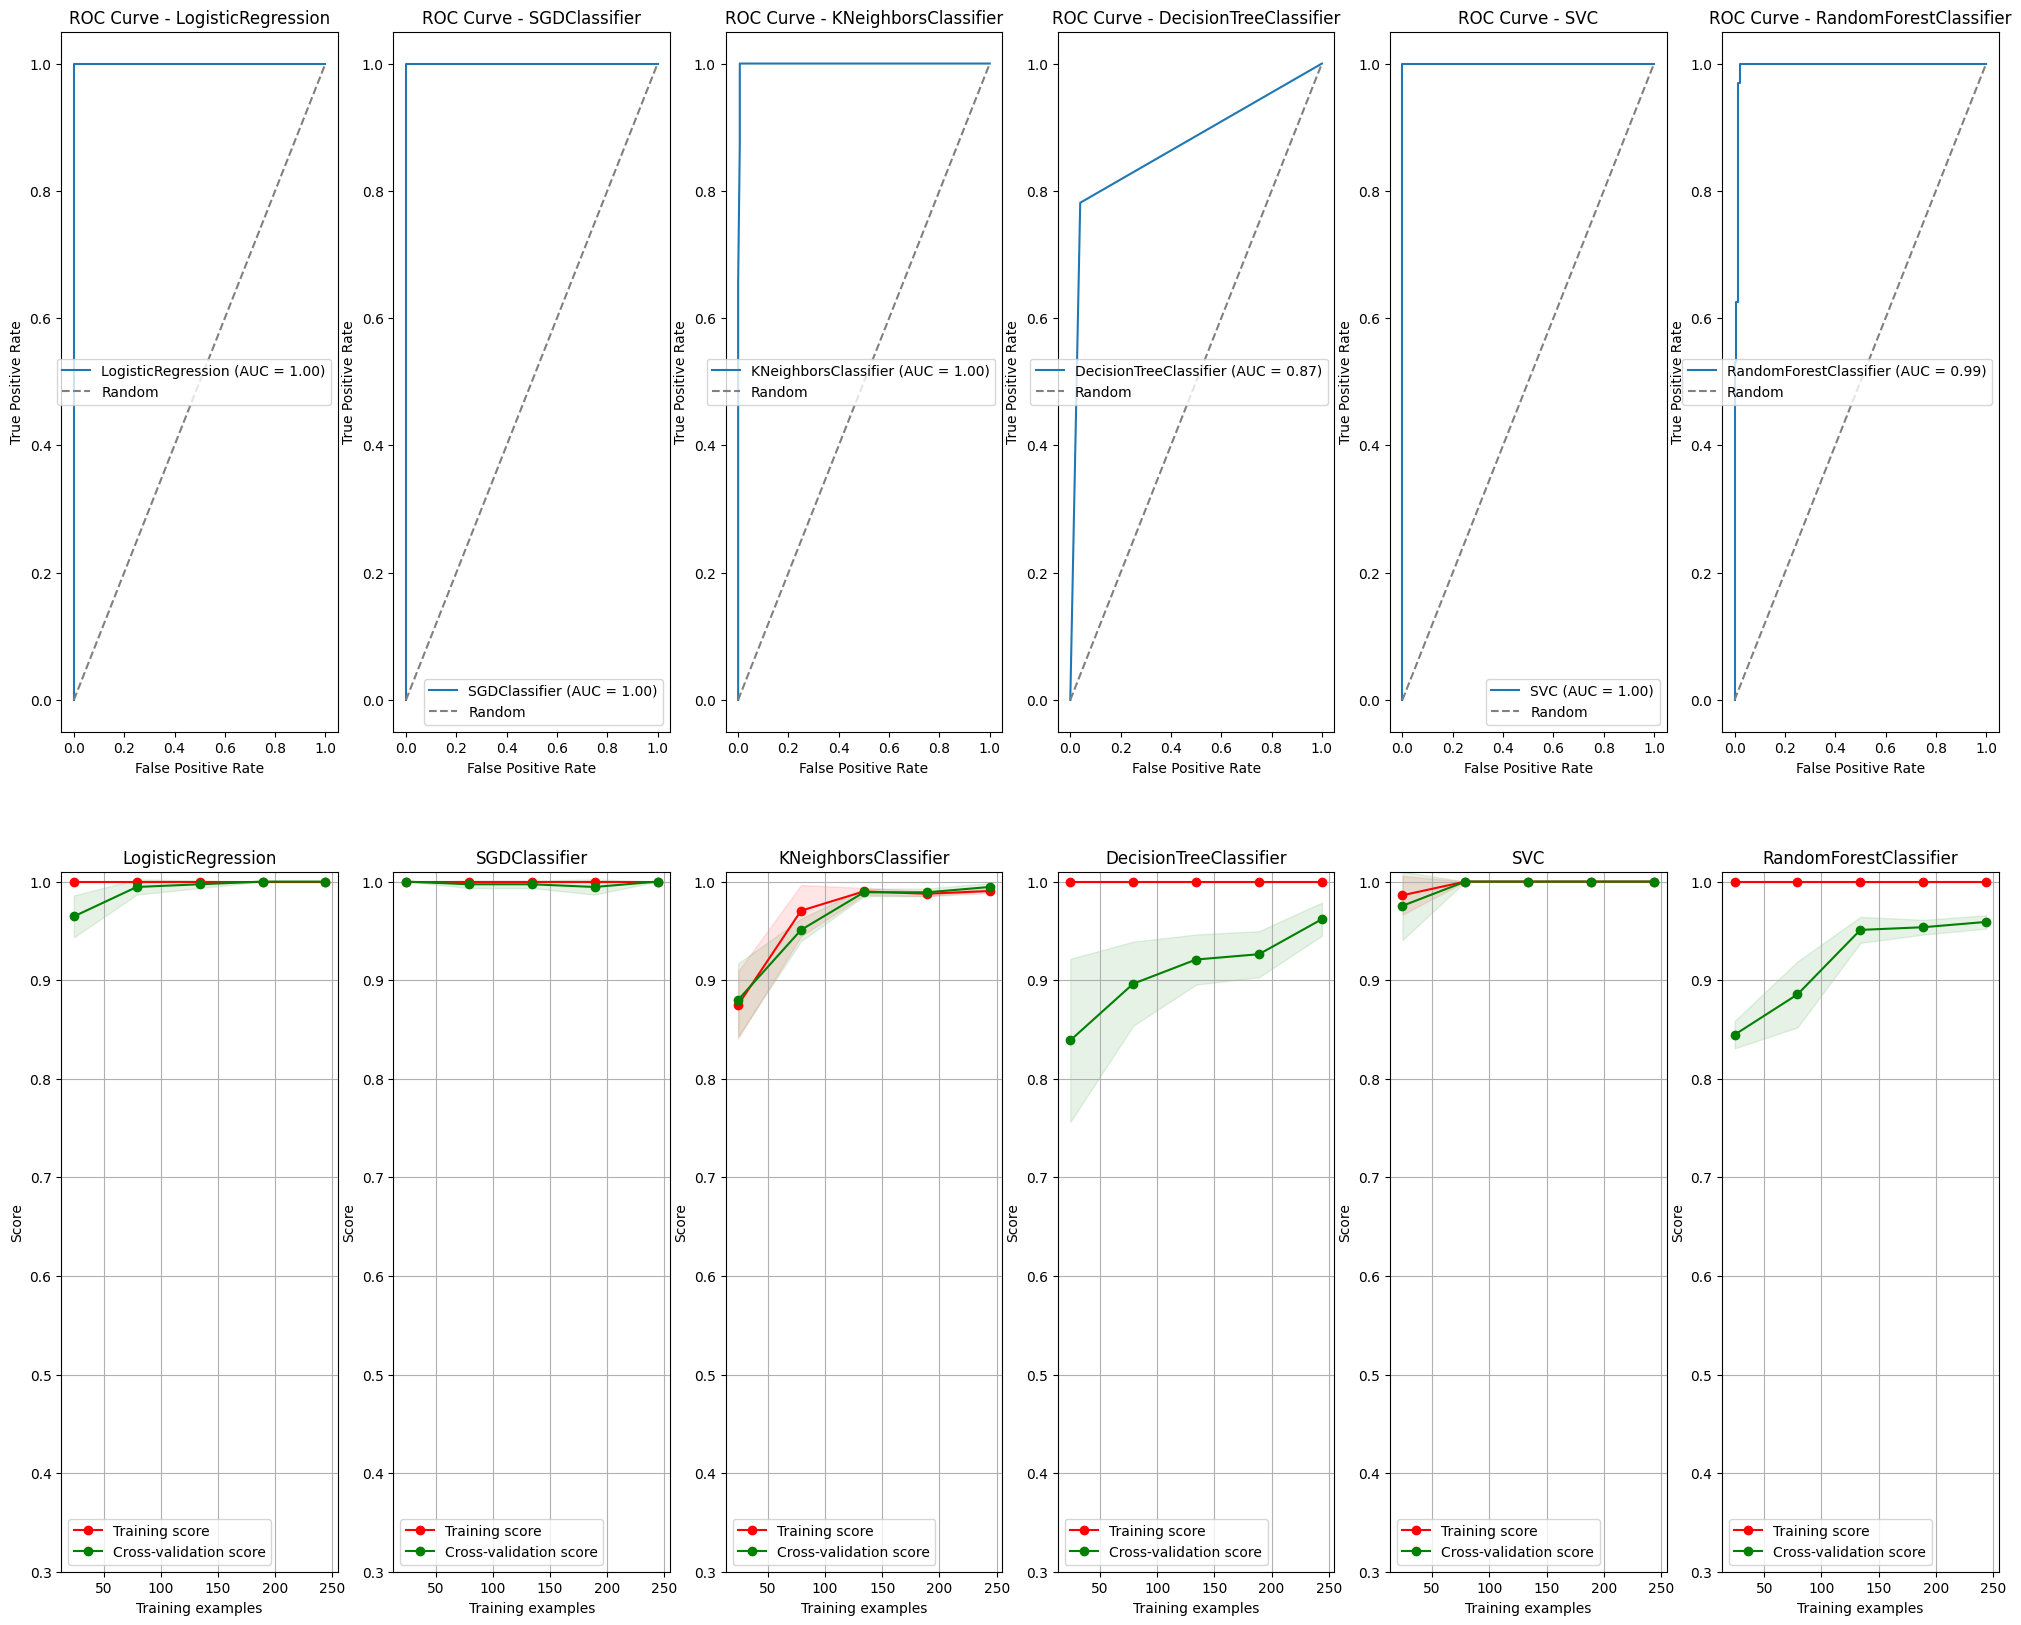

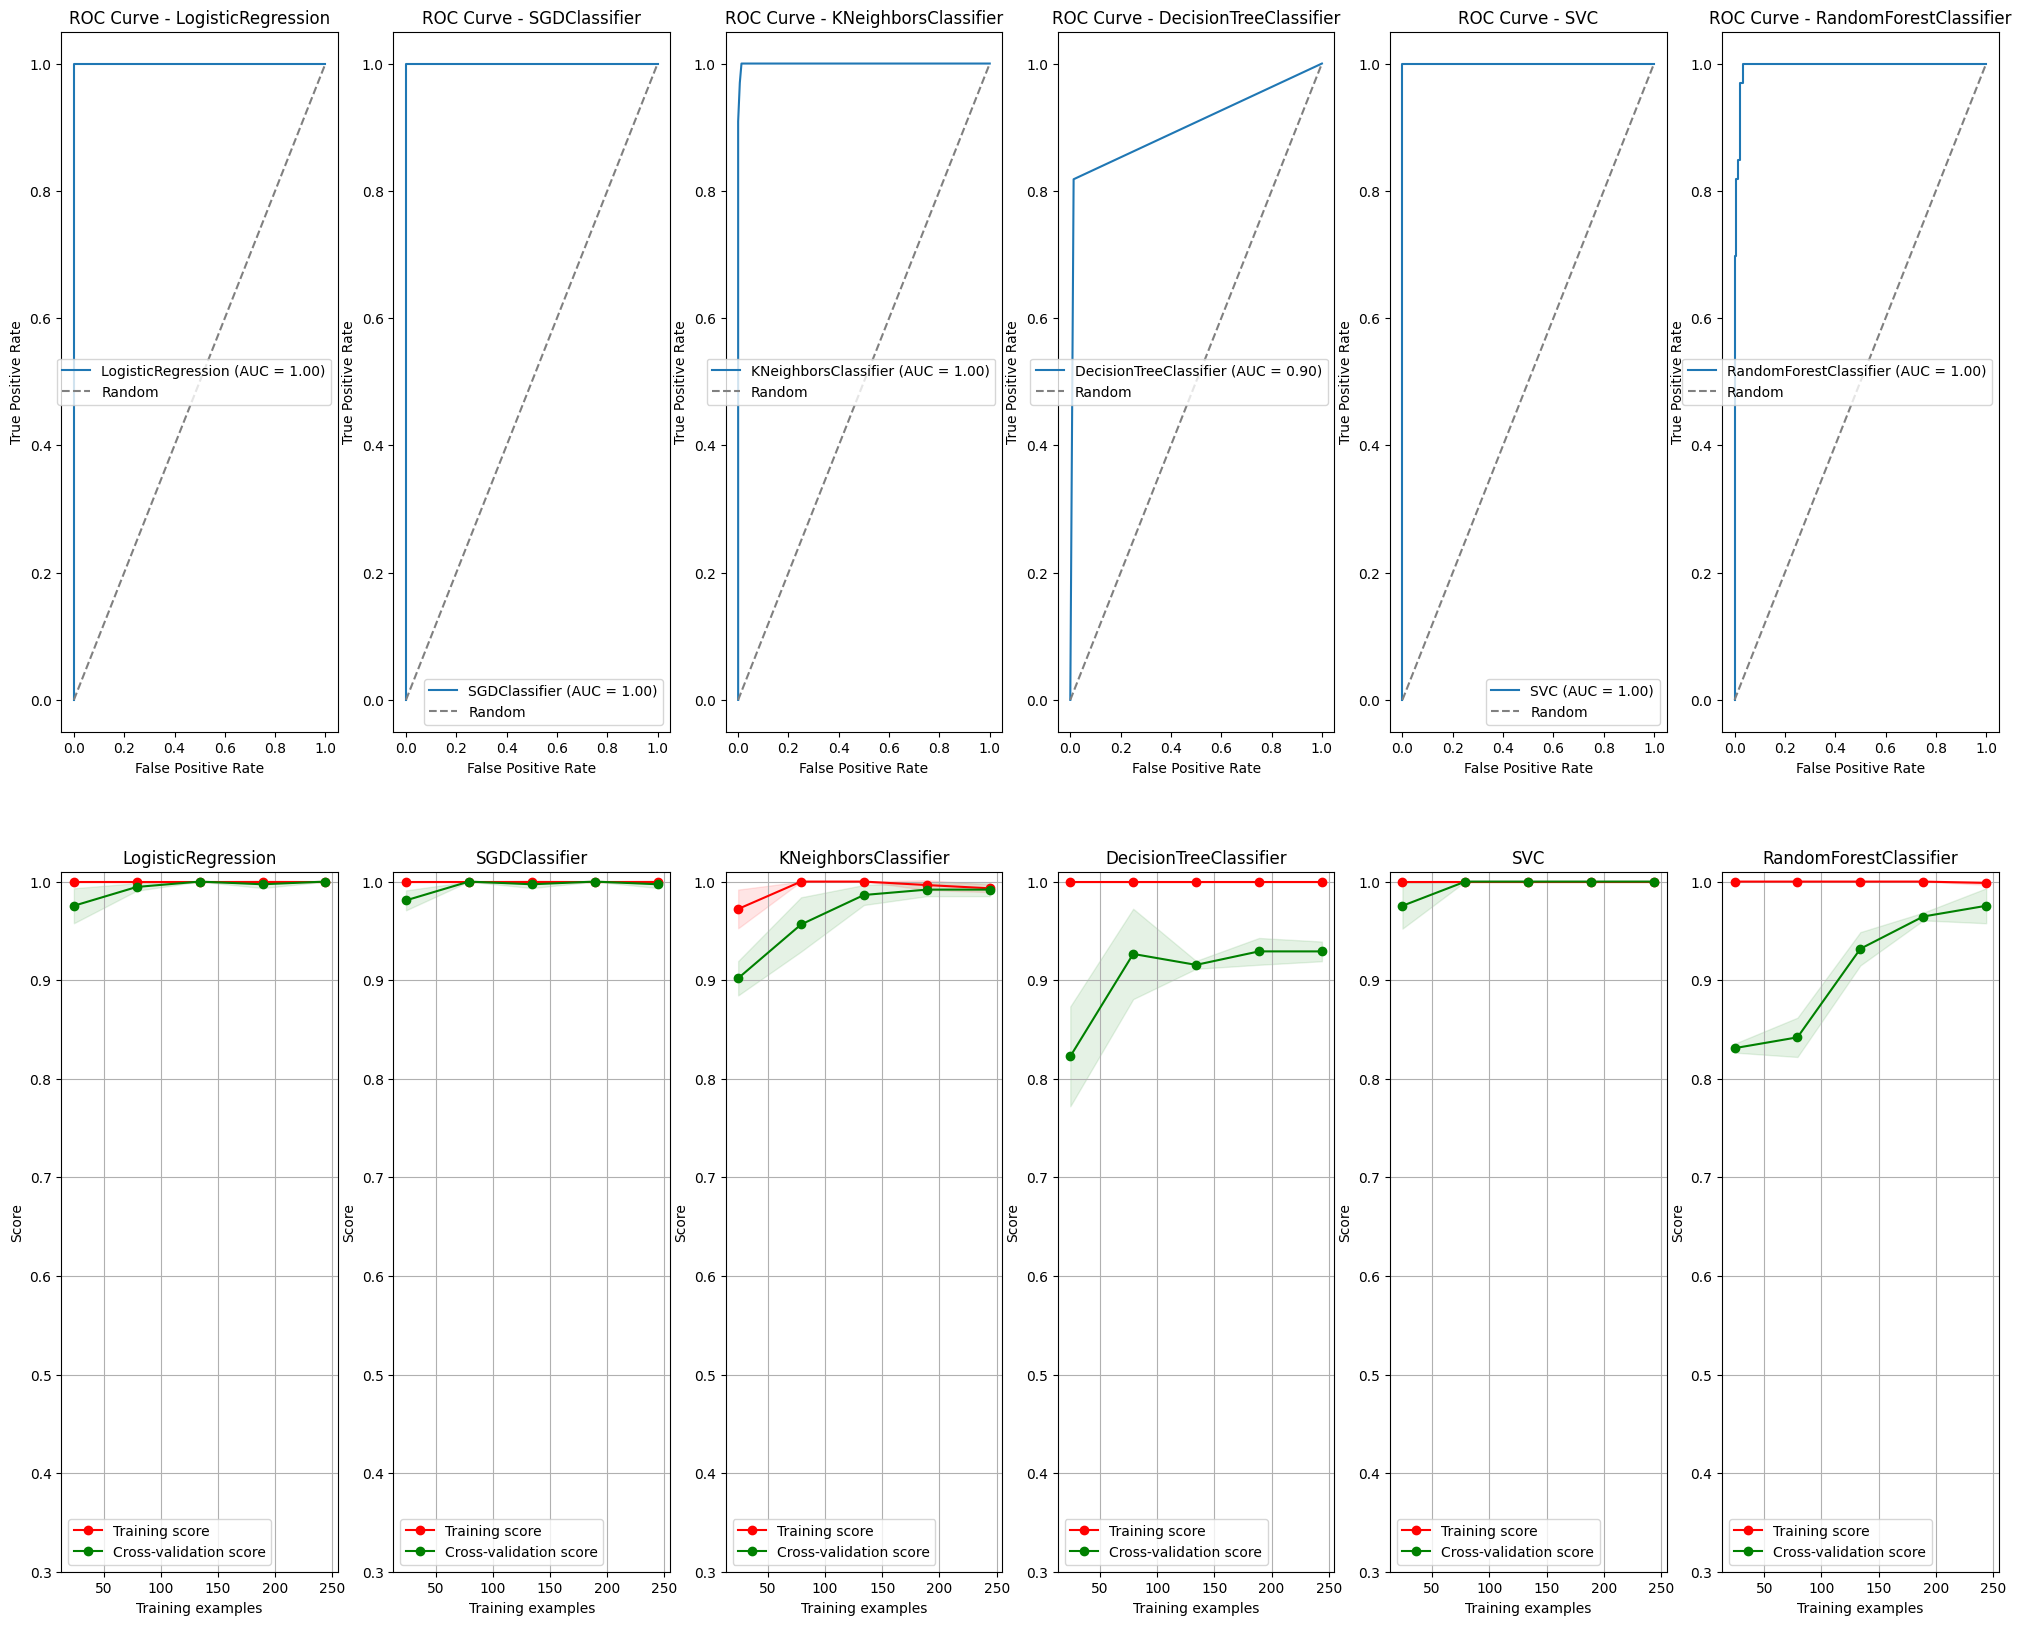

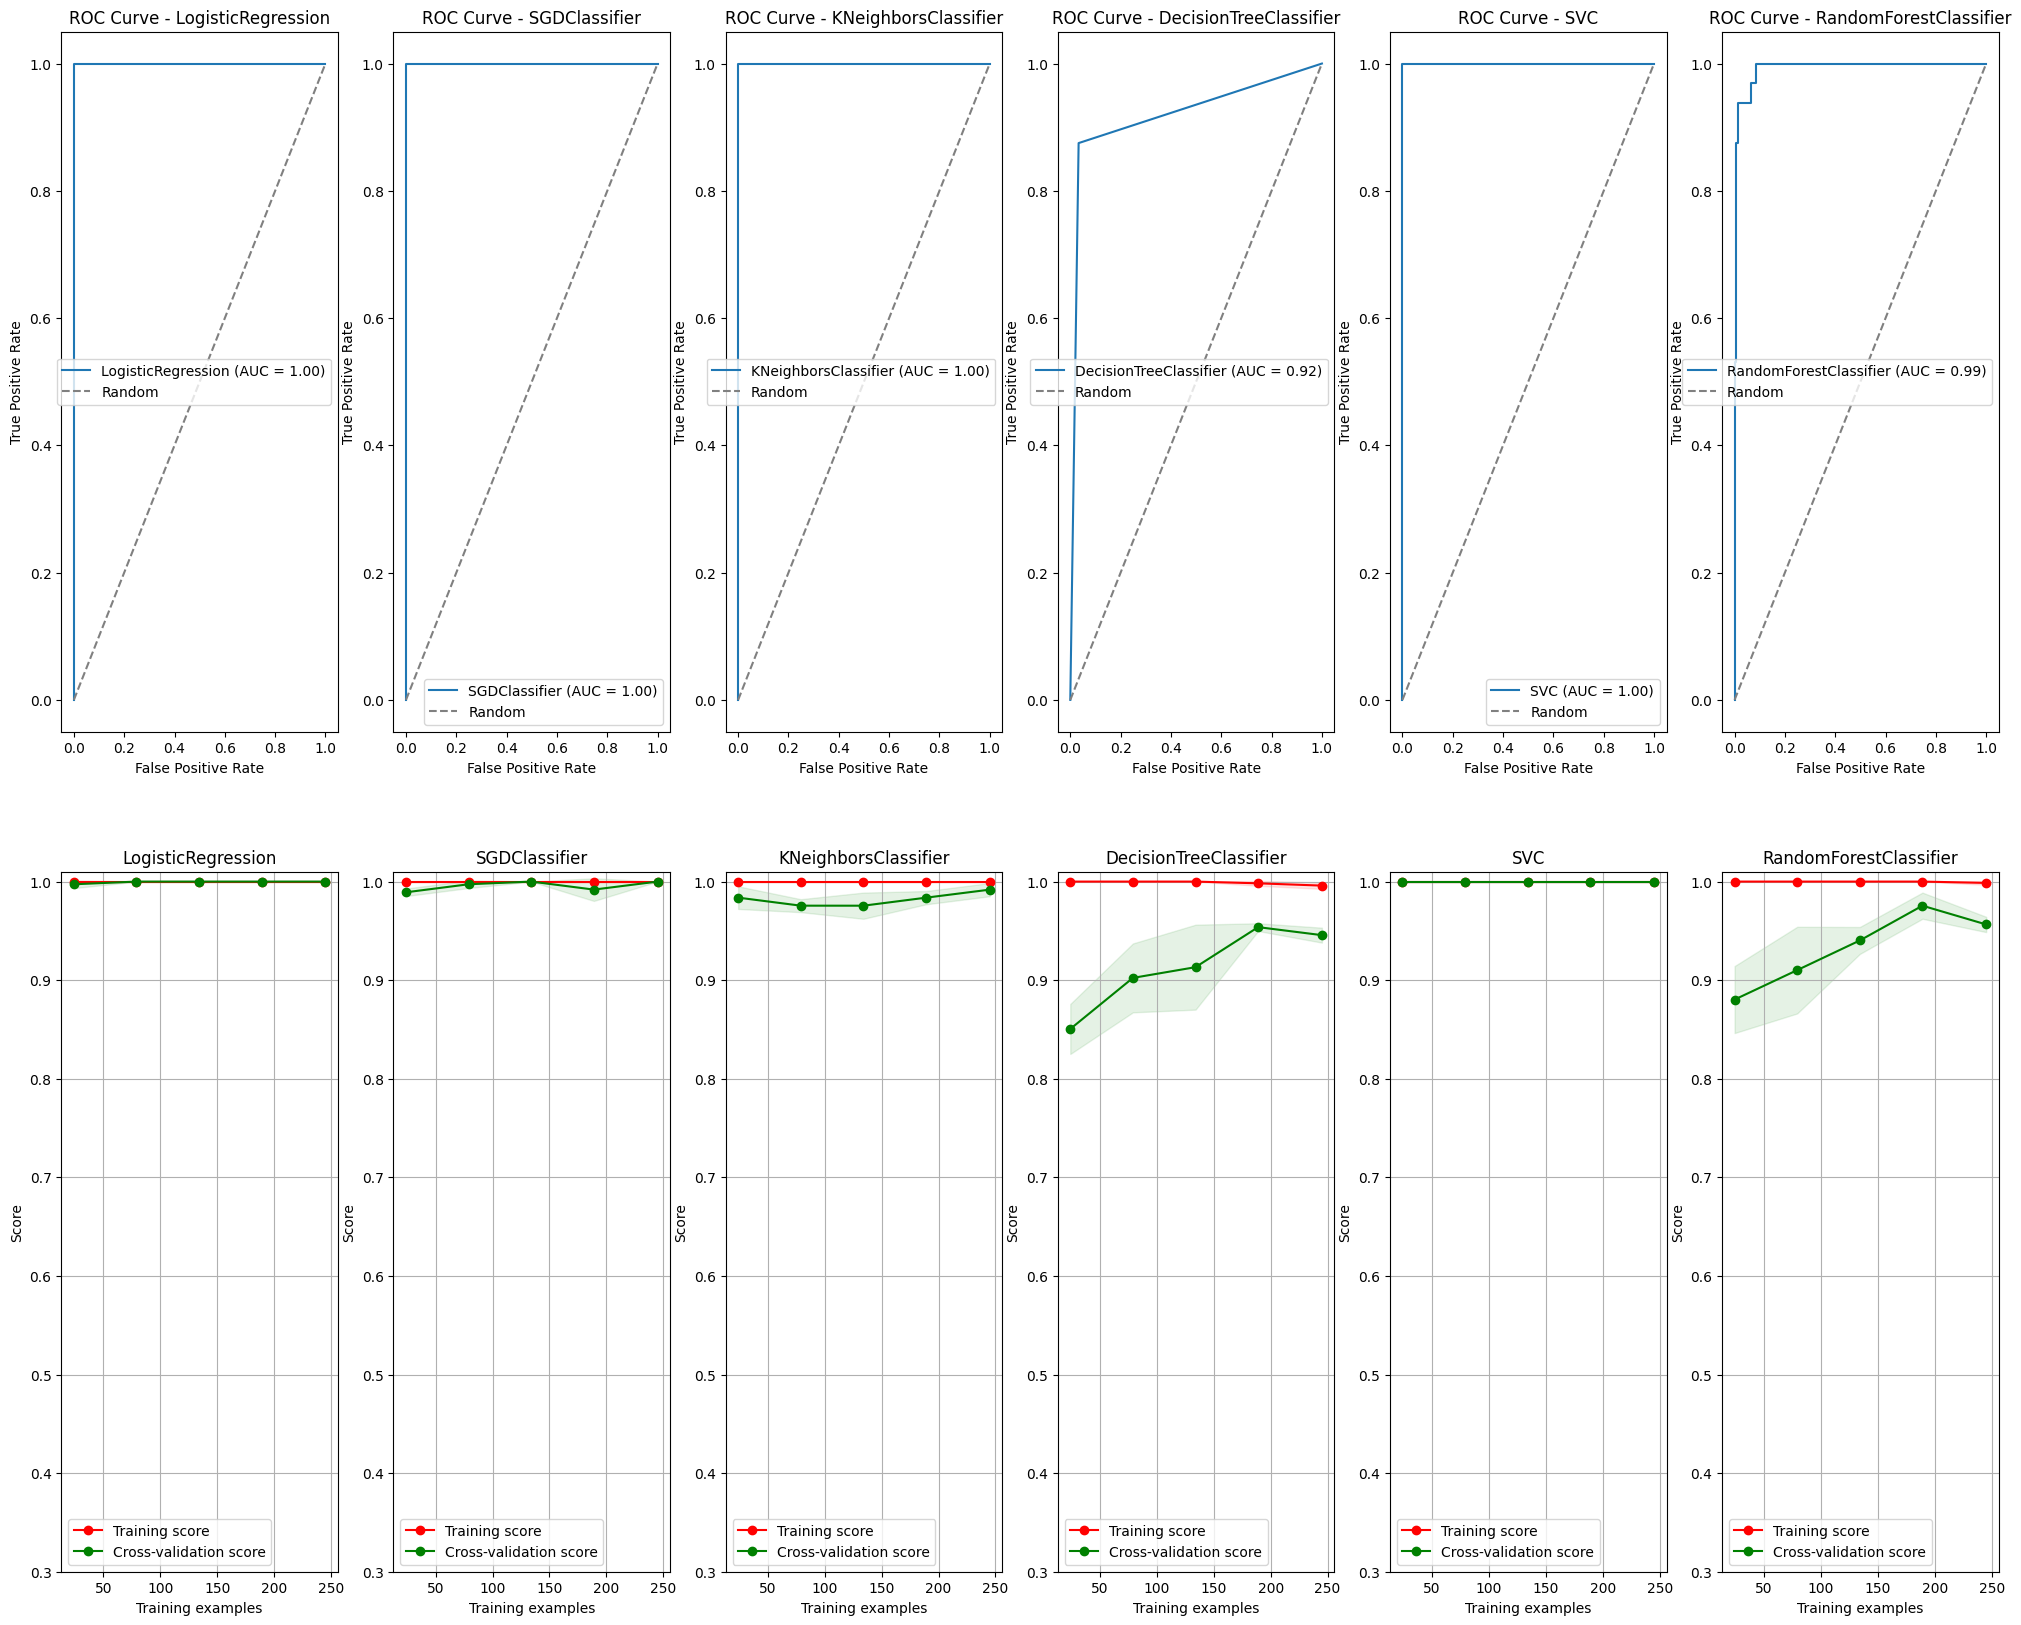

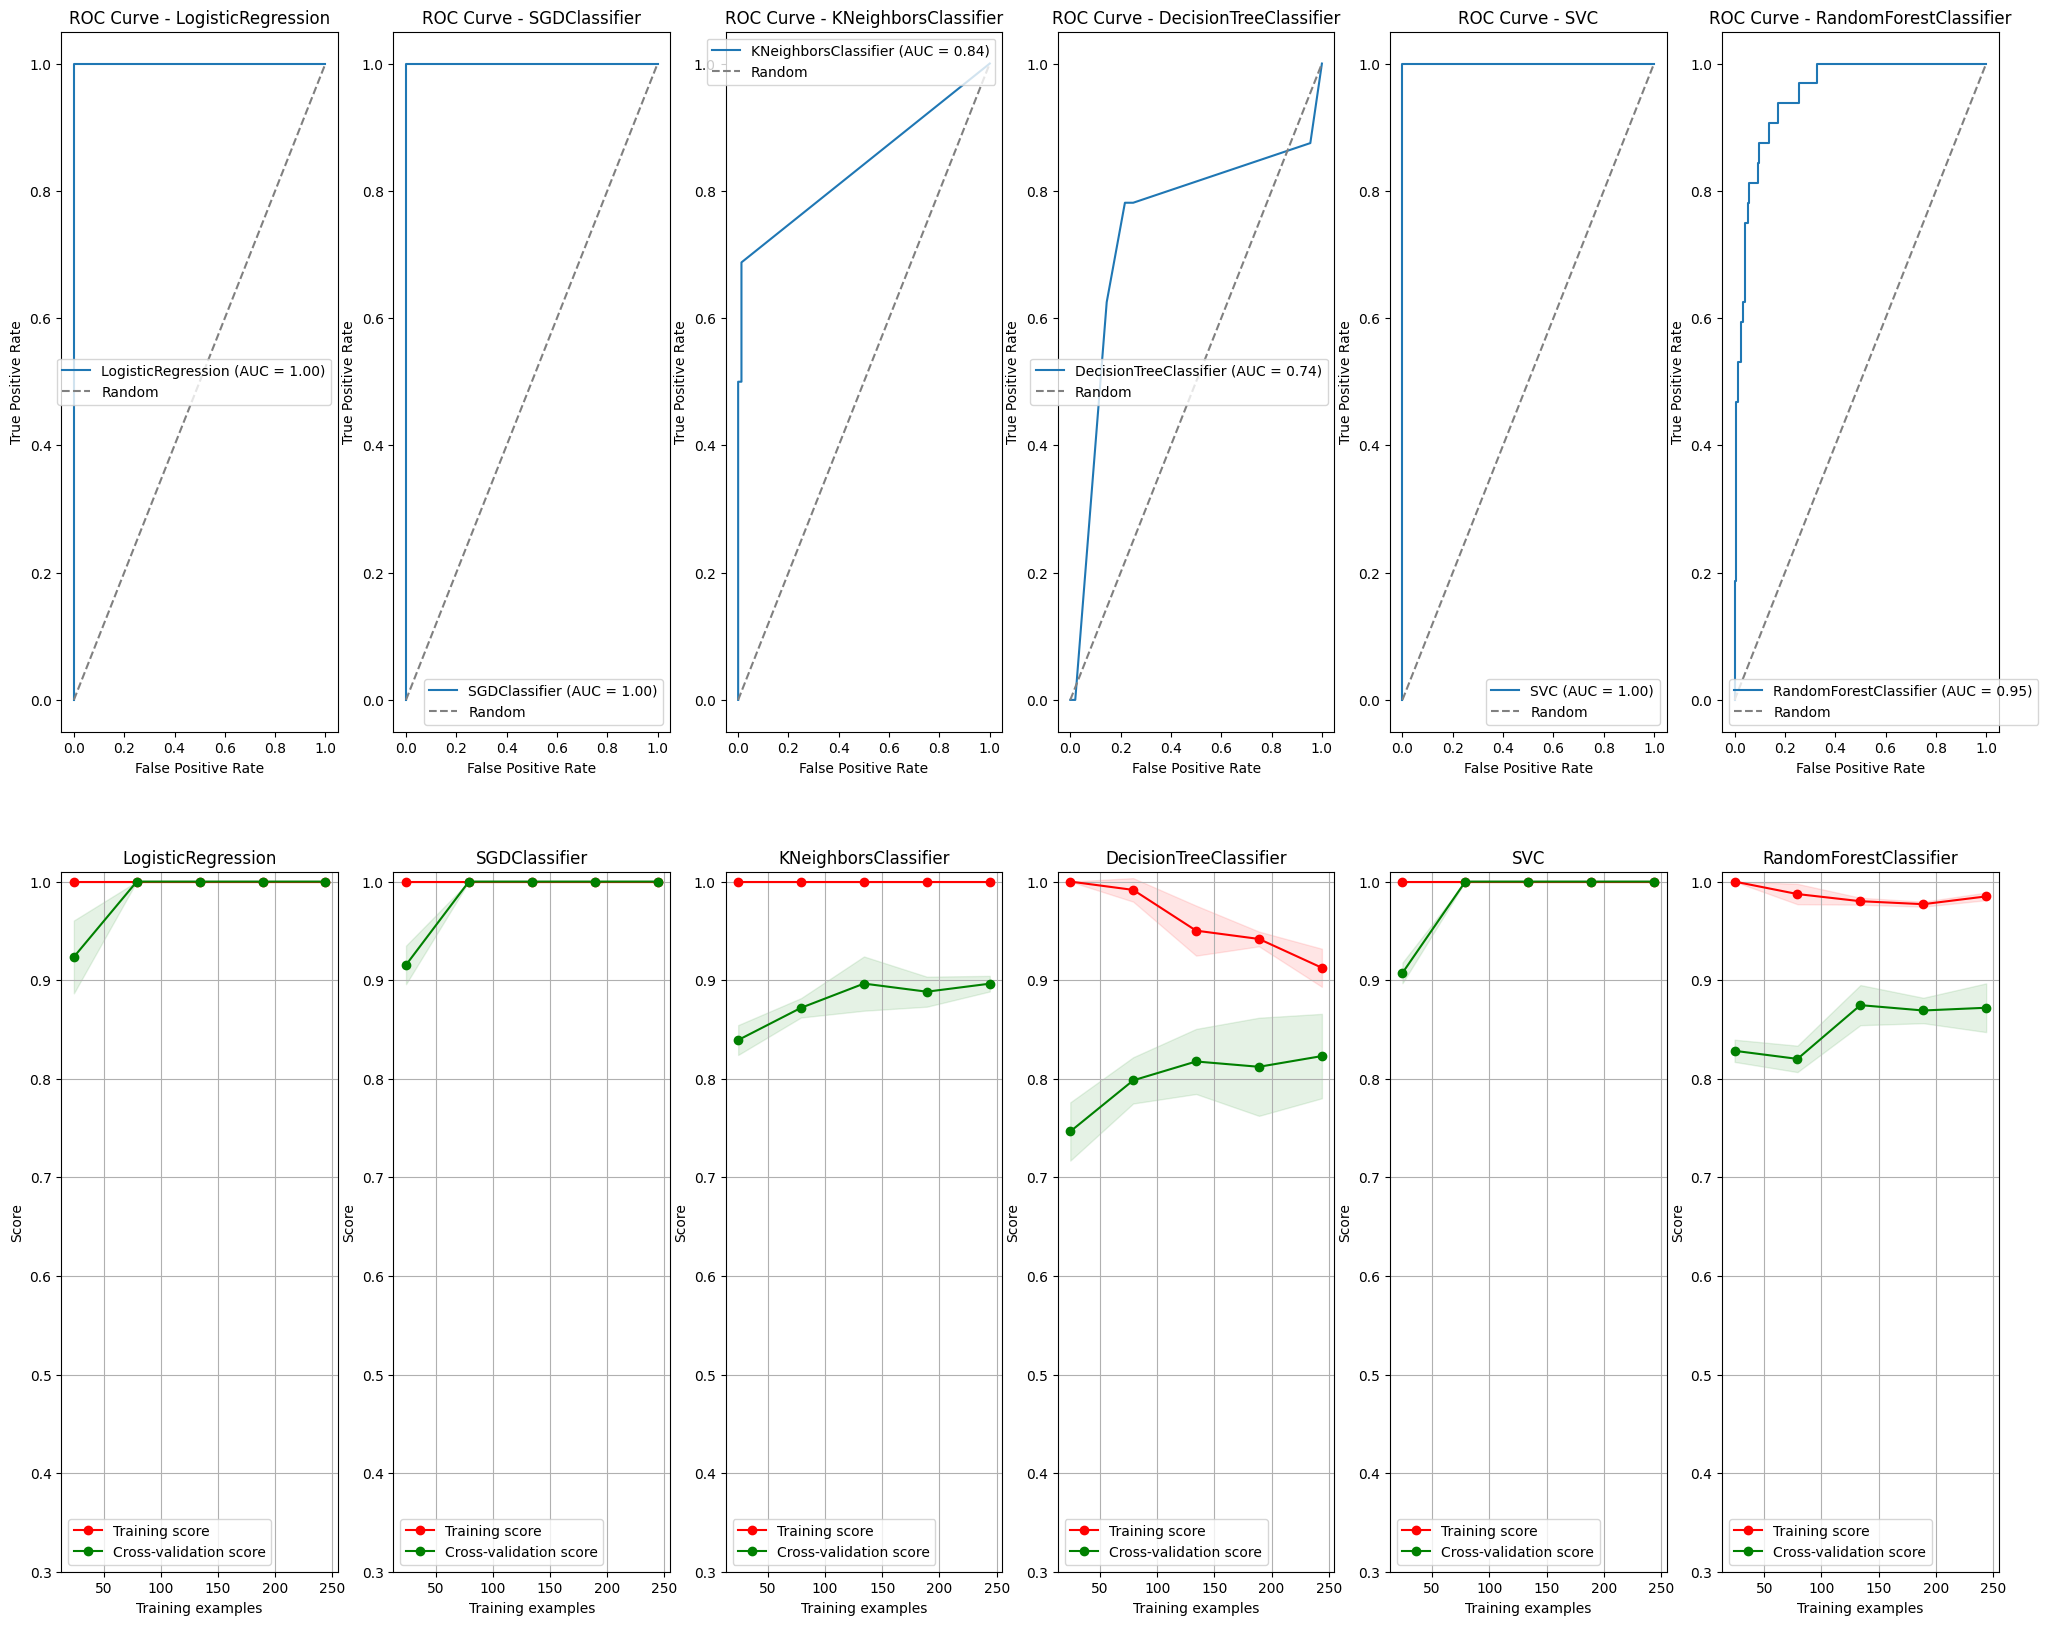

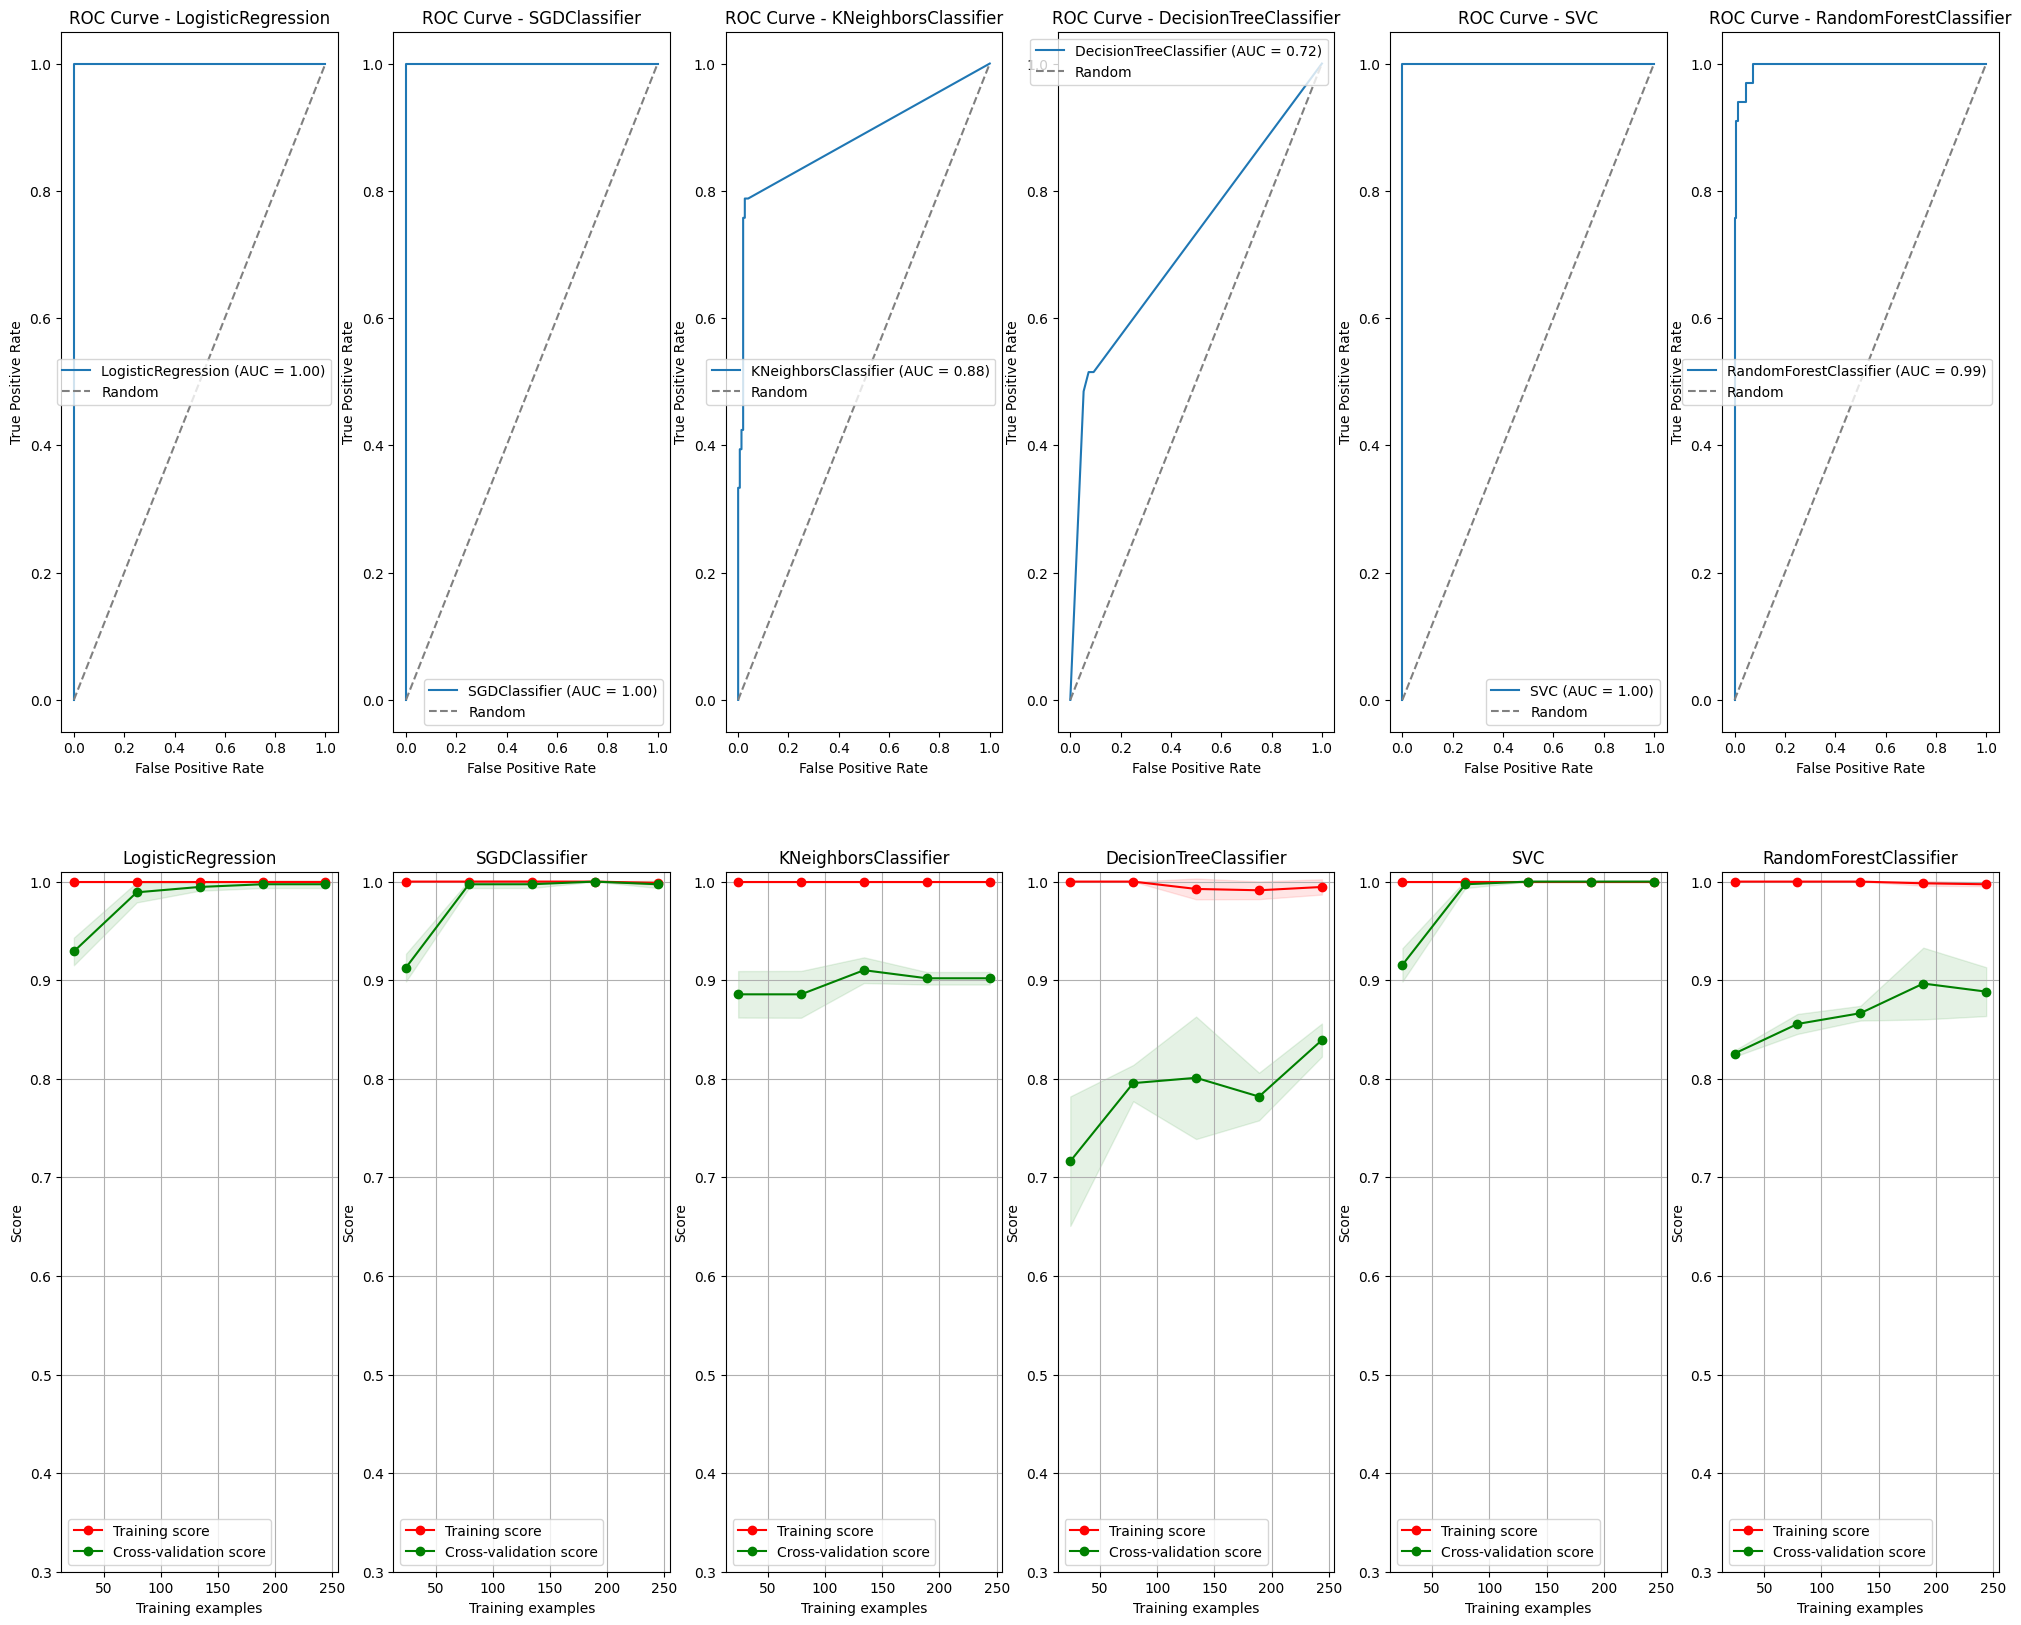

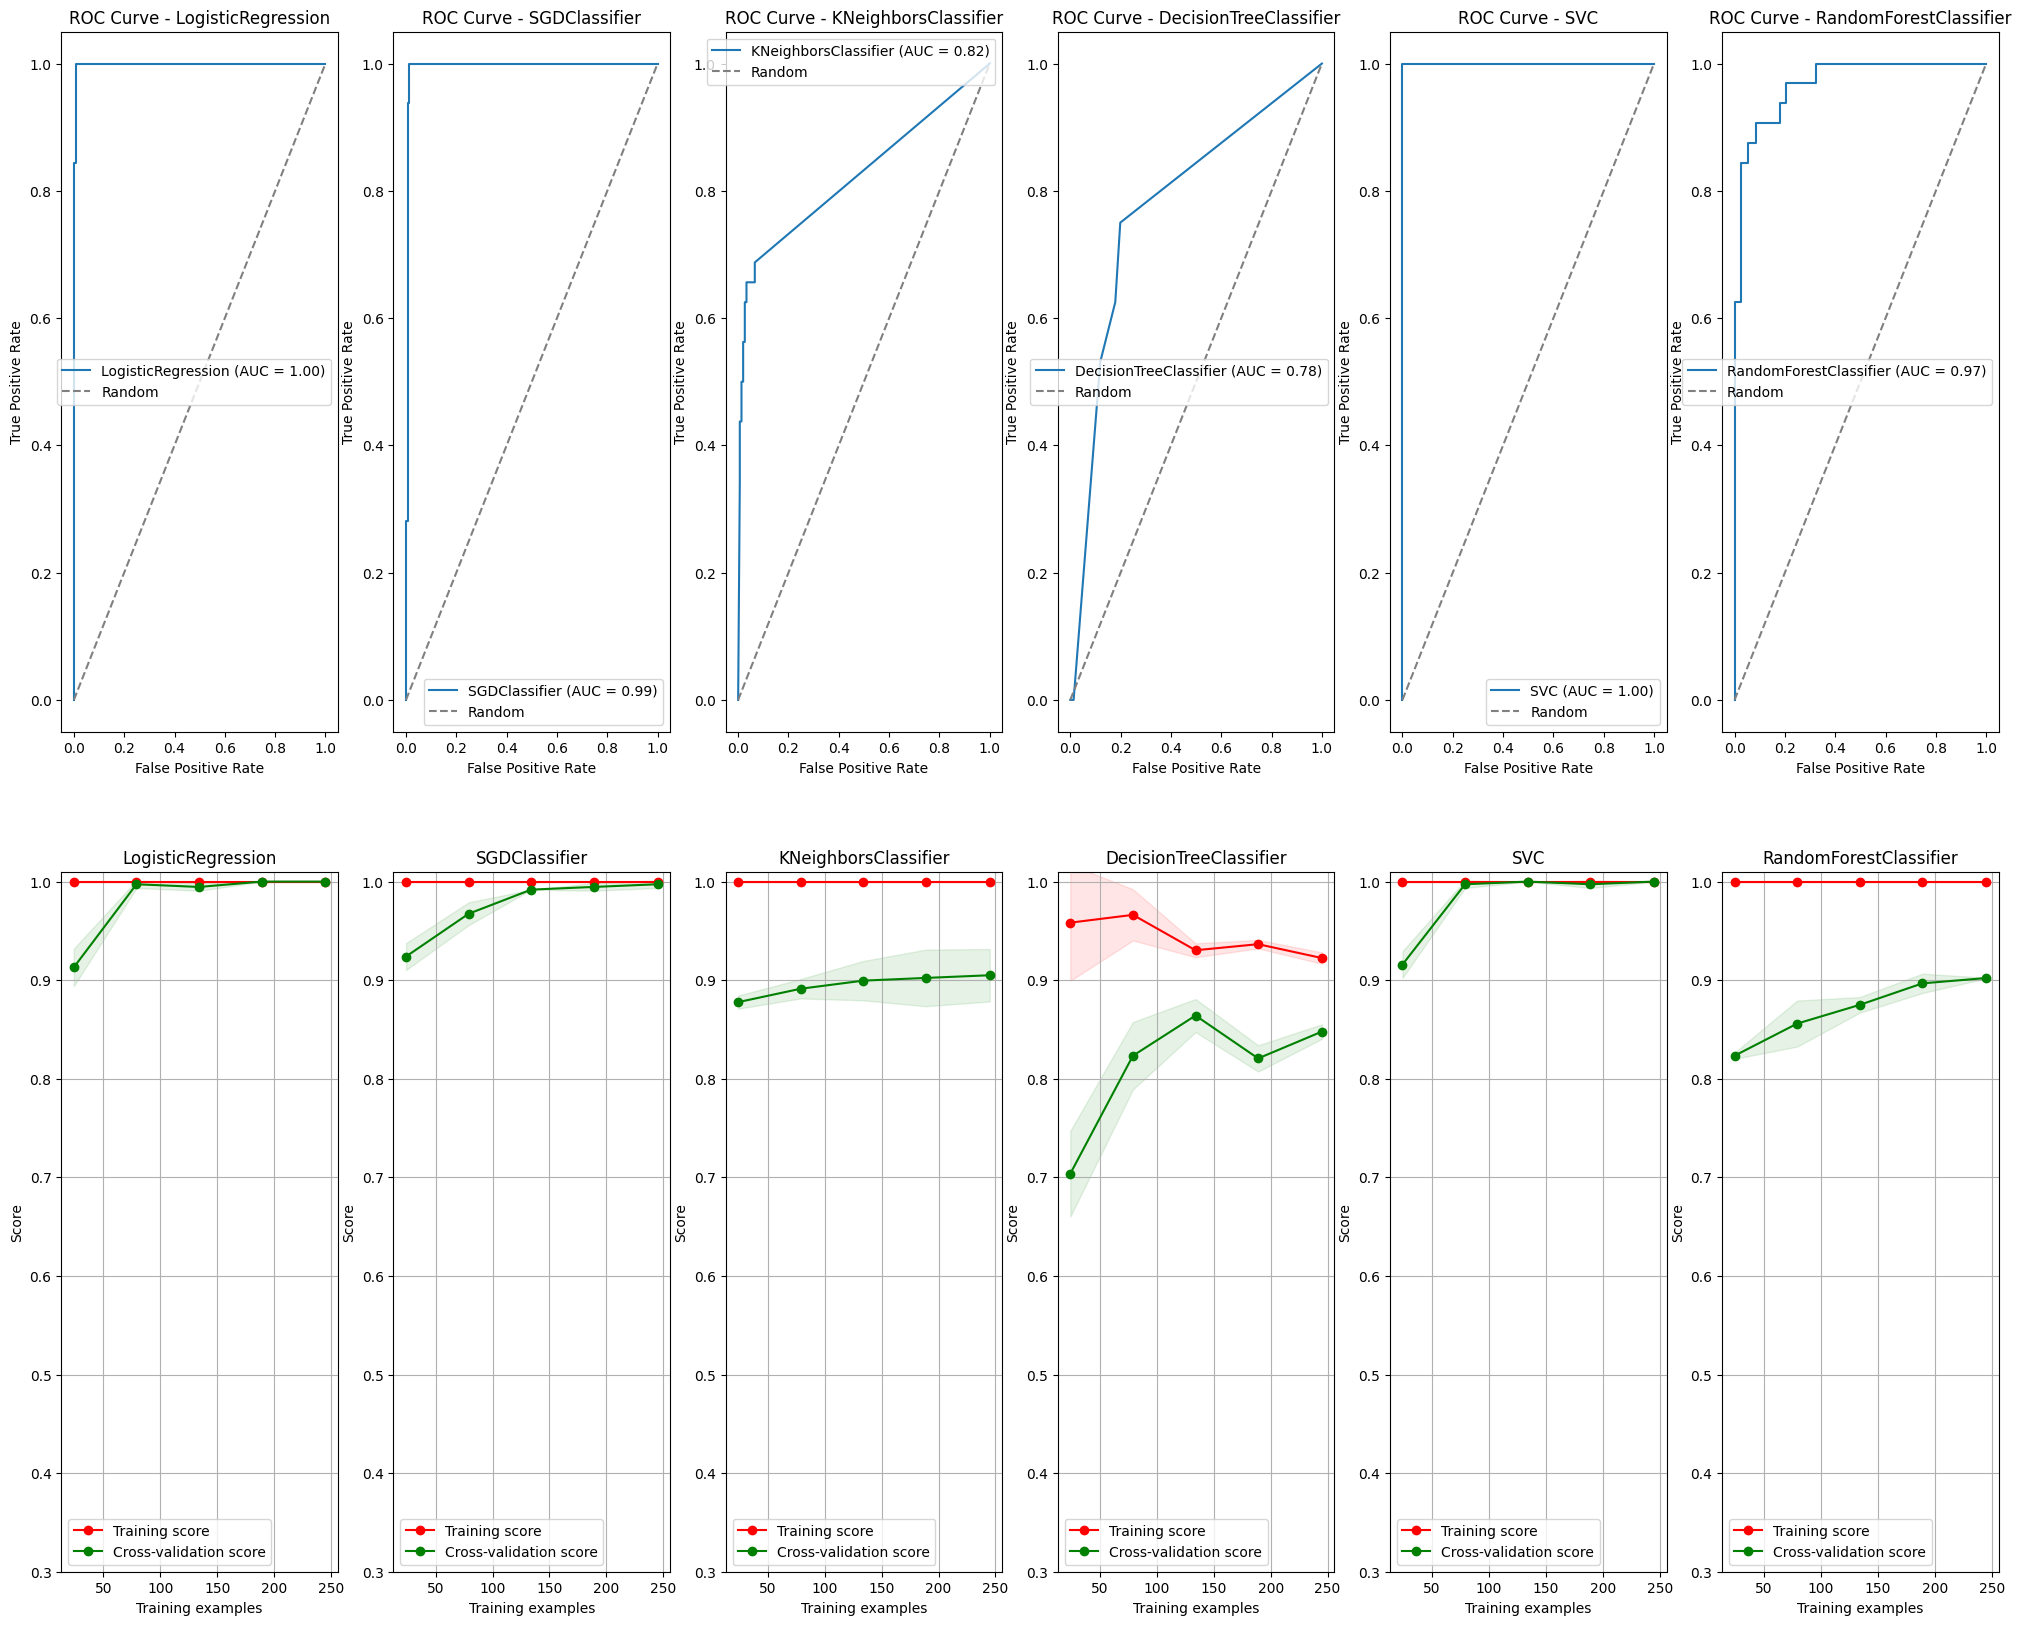

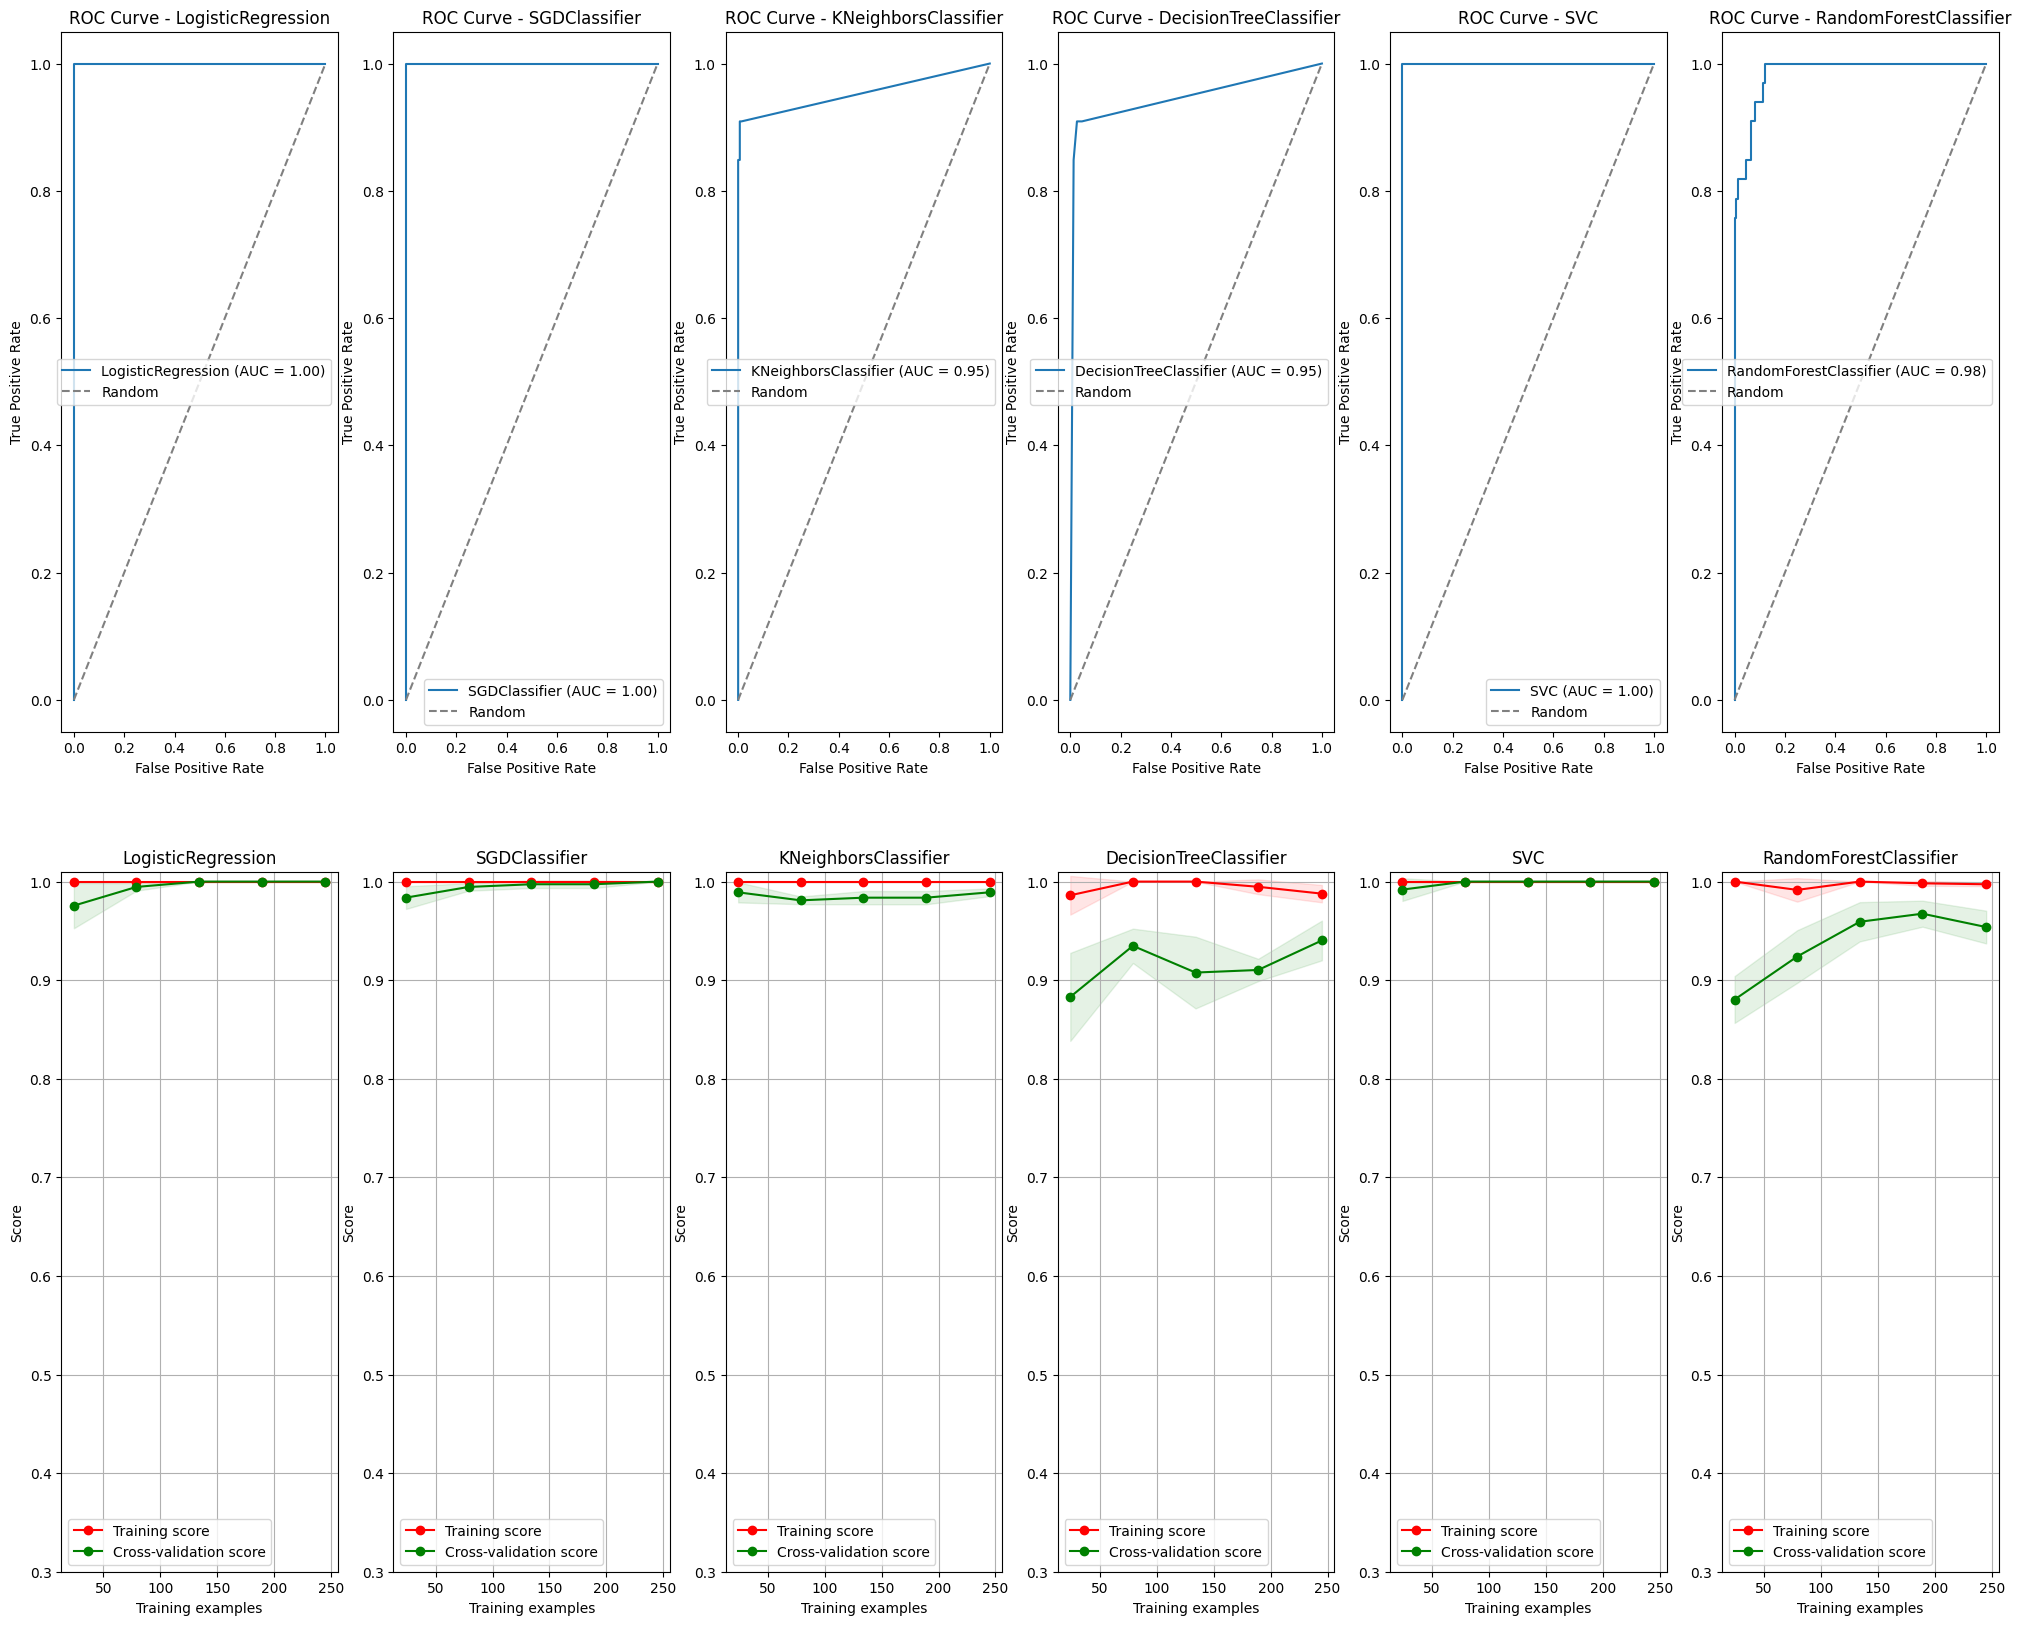

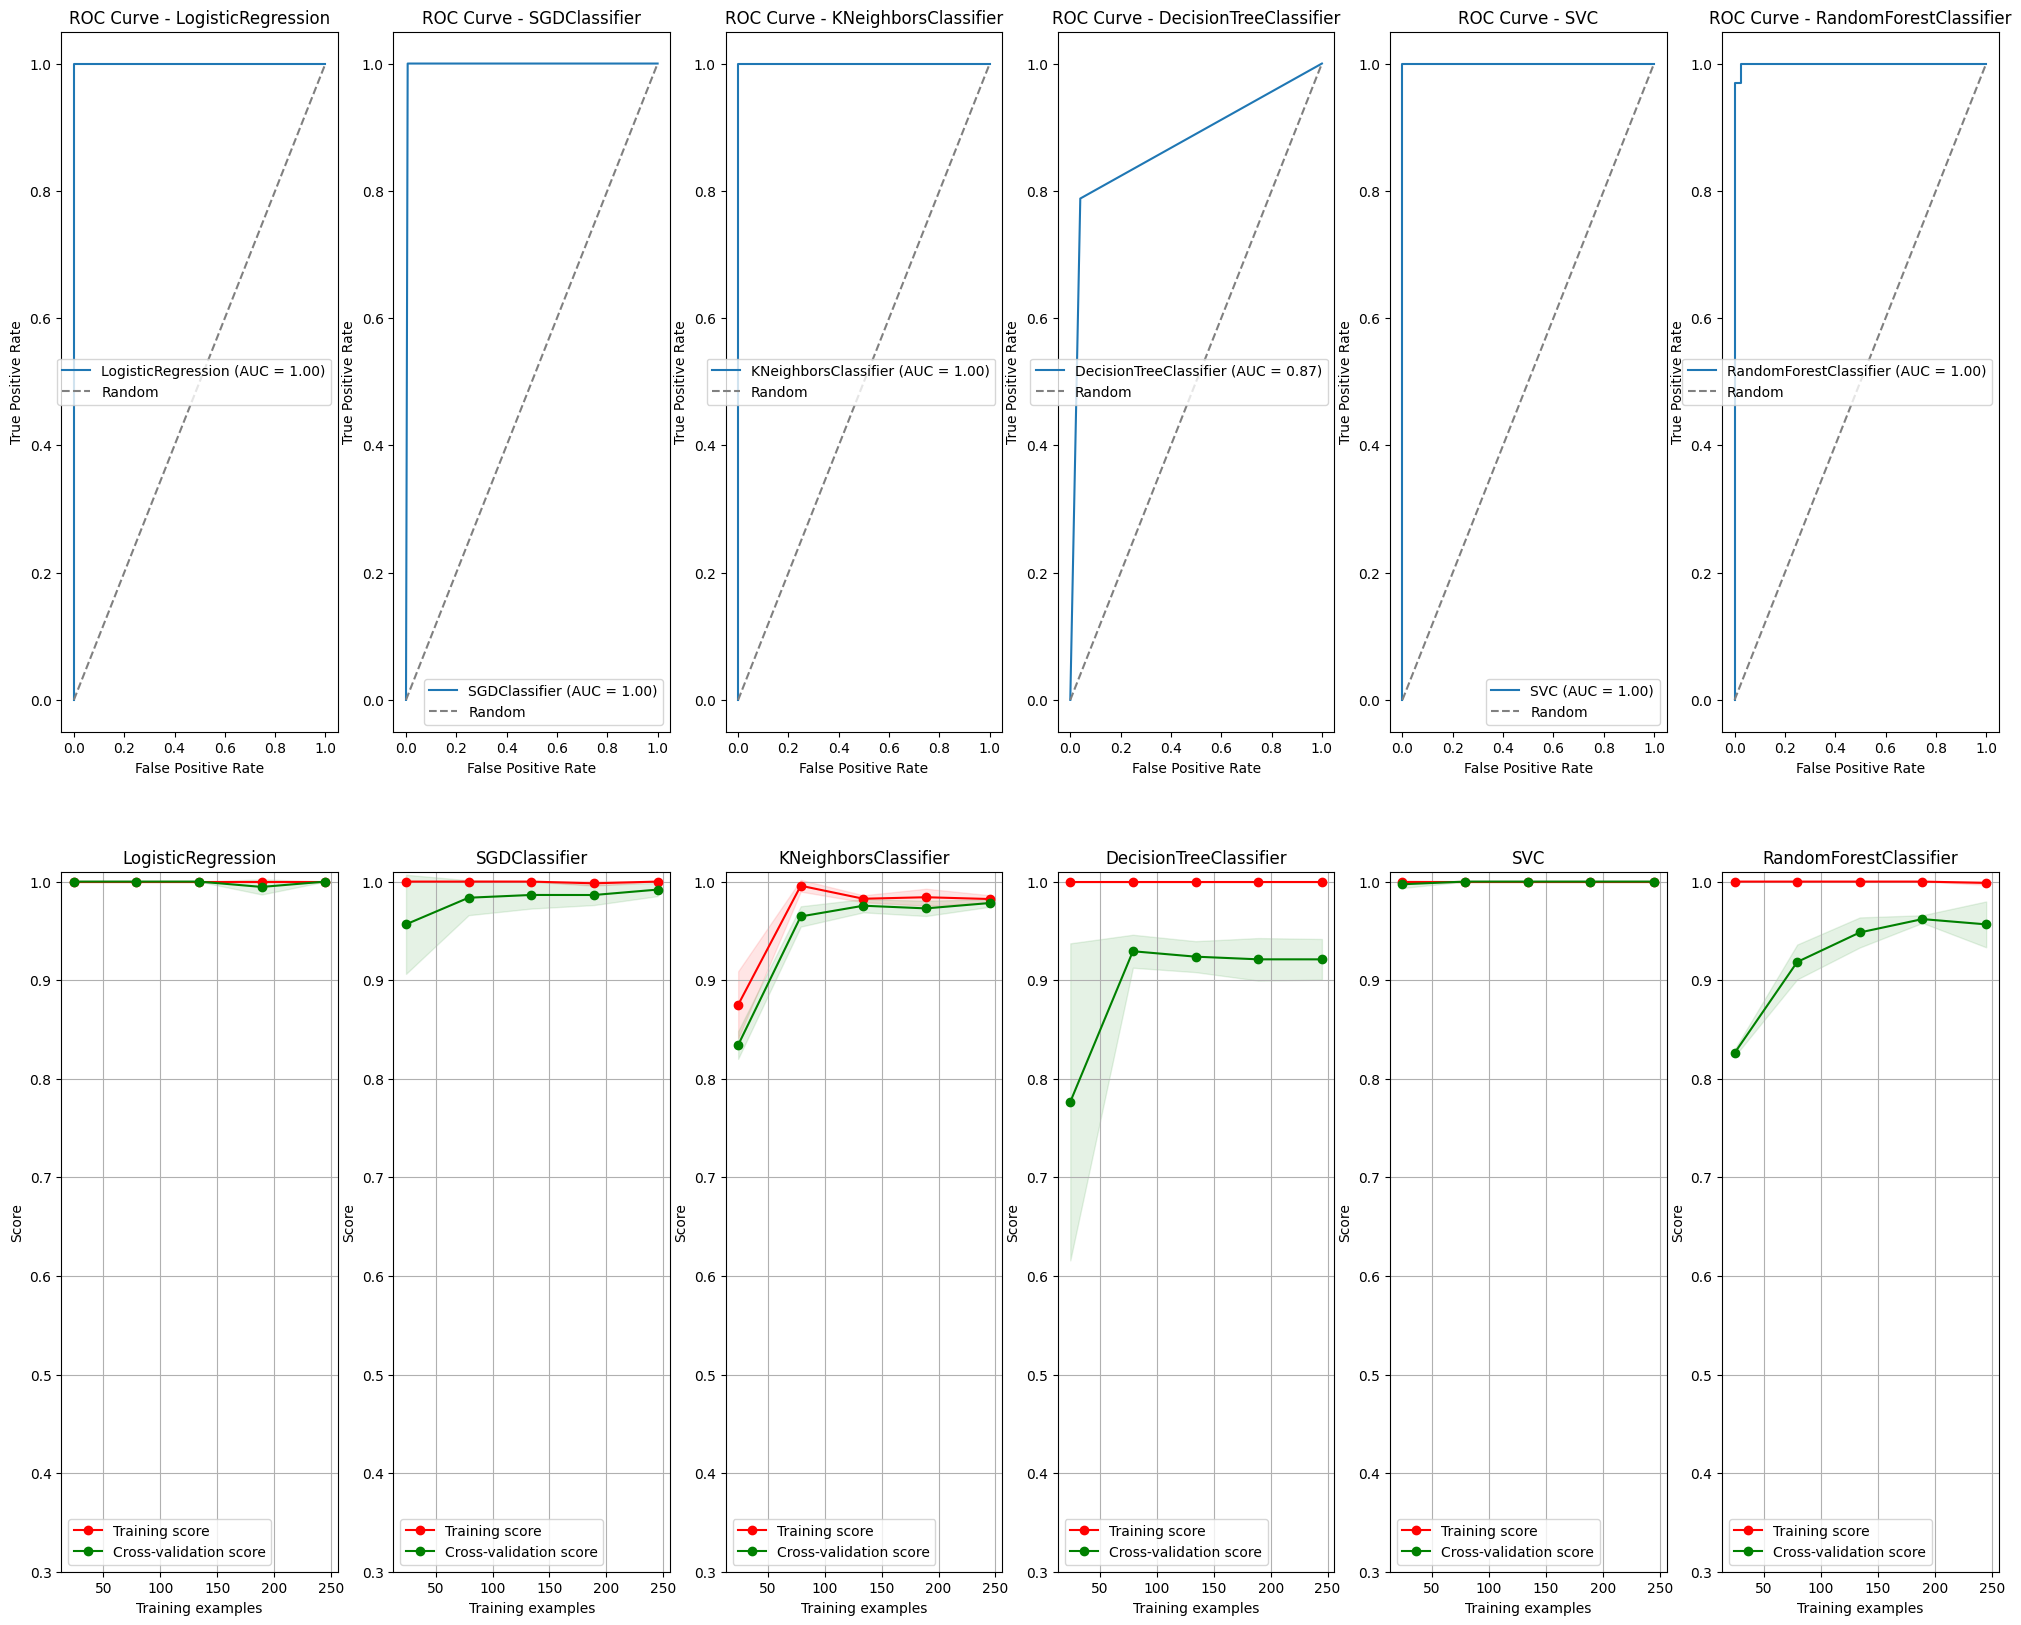

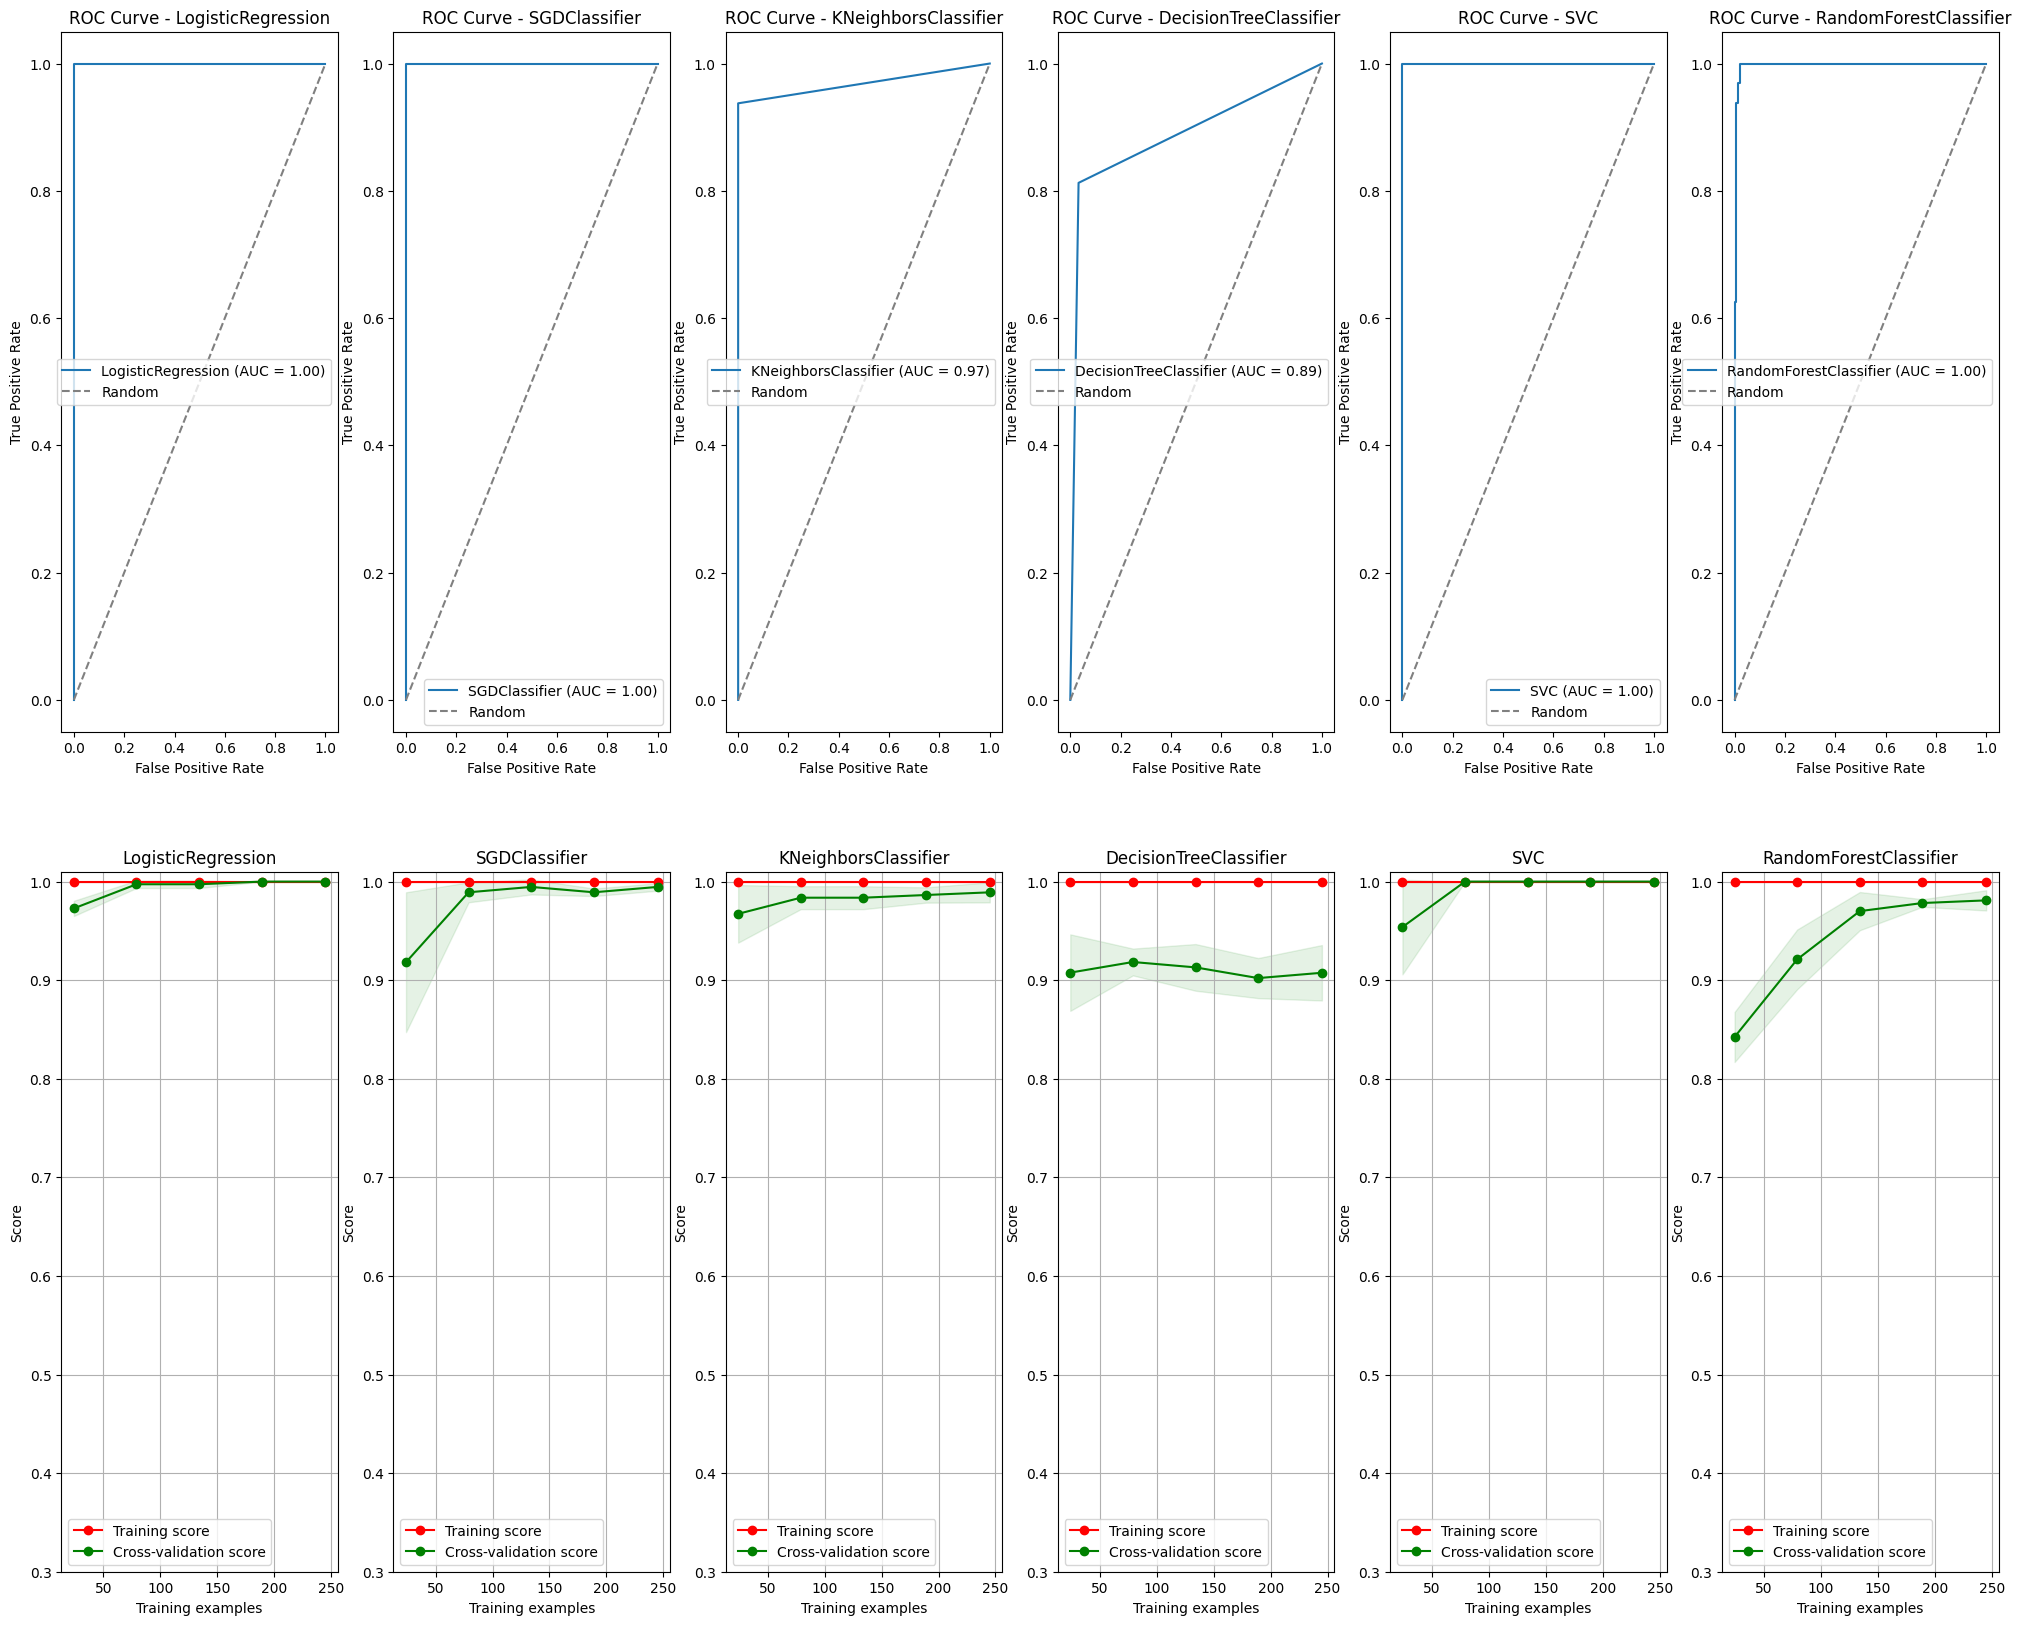

In [15]:
# Split data into label and data
label = data['label']
data_nolabel = data.drop('label', axis=1)

# K-fold outer cross-validation
k_folds = 3
cv_outer = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42) #random_state ensures same shuffling pattern


## Inner cross-validation
n_folds = 3
cv_inner = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42) #shuffle ensures no bias by ordered data

## Defining values
# Classifiers
classifiers = {
"LogisticRegression": LogisticRegression(class_weight='balanced'),
"SGDClassifier": SGDClassifier(class_weight='balanced'),
"KNeighborsClassifier": KNeighborsClassifier(),
"DecisionTreeClassifier": DecisionTreeClassifier(class_weight='balanced'),
"SVC": SVC(class_weight='balanced'),
"RandomForestClassifier": RandomForestClassifier(class_weight='balanced')}

# Hyperparameters per classifier
param_grids = {
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10],  # Regularization strength
        "penalty": ['l2', 'l1'],  # Regularization type
        "solver": ['liblinear']},  # Optimization algorithm
    "SGDClassifier": {
        "loss": ['hinge', 'log_loss', 'modified_huber'],  # Loss function
        "penalty": ['l2', 'l1'],  # Regularization type
        "alpha": [0.001, 0.01, 0.1]},  # Regularization amount
    "KNeighborsClassifier": {
        "n_neighbors": [2, 3, 5, 7, 9],  # Number of neighbors
        "weights": ['uniform', 'distance']},  # Weighting scheme
    "DecisionTreeClassifier": {
        "max_depth": [3, 5, 7, 9, 11],  # Tree depth
        "min_samples_split": [2, 5, 10, 15]},  # Minimum samples for split
    "SVC": {
        "kernel": ['linear', 'rbf', 'poly'],  # Kernel type
        "degree": [2, 3, 5],  # Polynomial degree
        "C": [0.1, 1, 10]},  # Regularization parameter
    "RandomForestClassifier": {
        "n_estimators": [1, 5, 10, 50],  # Number of trees
        "max_depth": [3, 5, 7, 9, 11]}}  # Tree depth

f1_threshold = 0.35
precision_recall_list = []

# Loop per training set
for train1_index, test_index in cv_outer.split(data_nolabel, label):
    # Split data into first train and test sets
    X_train1, X_test = data.iloc[train1_index], data.iloc[test_index]
    y_train1, y_test = label.iloc[train1_index], label.iloc[test_index]

    ### Pre-processing
    ## Separate labels
    # Check which label is normal and abnormal
    if sum(data['label']) > len(data) / 2: # Biggest class is 'normal'
        normal_data = data[label == 0]
        abnormal_data = data[label == 1]
    else:
        normal_data = data[label == 1]
        abnormal_data = data[label == 0]

    ## Missing data handling
    # Change None into median of training data
    data_train_clean = X_train1.copy()
    imputer = SimpleImputer(strategy='median')
    data_train_clean[:] = imputer.fit_transform(data_train_clean)

    ## Scaling
    # Check for normal distribution of features
    p_values = data_train_clean.apply(lambda col: normaltest(col)[1]) # Test normality of each feature
    non_normal_features = (p_values < 0.05).sum() # a p-value > 0.05 means it is not normally distributed

    # Find outliers in data
    def count_outliers(df):
      '''function to detect outliers in data'''
      Q1 = df.quantile(0.25)
      Q3 = df.quantile(0.75)
      IQR = Q3 - Q1 # Spread of the middle 50% of data
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outliers = ((df < lower_bound) | (df > upper_bound)).sum()
      return outliers

    outlier_counts = count_outliers(data_train_clean)
    mean_outliers = outlier_counts.mean()
    features_with_many_outliers = (outlier_counts > 0.1 * len(data_train_clean.index)).sum()

    # Robust scaler chosen: based on normal distribution and outliers
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_train_clean)

    ## Feature selection
    # 1. Univariate statistical testing: ANOVO f-test
    # Number of features where p < 0.05
    f_scores, p_values = f_classif(data_scaled, y_train1)
    k_best = np.sum(p_values < 0.05) # Only features with p_value < 0.05

    selector = SelectKBest(f_classif, k=k_best)
    data_selected = selector.fit_transform(data_scaled, y_train1)
    print(f'Univariatiate statistical feature selection performed: {k_best} features selected.')

    # 2. Dimensionality reduction with PCA
    # Number of components where variance ≥99%
    pca_full = PCA().fit(data_selected)
    explained_var = pca_full.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    pca_components = np.argmax(cumulative_var >= 0.90) + 1

    pca = PCA(n_components=pca_components) # Reduce to features so that variance > 0.99
    data_final_selected = pca.fit_transform(data_selected)
    print(f'PCA feature selection performed: {pca_components} features left.')

    clf_params = {}
    auc_scores = {}
    f1_scores = {}
    ensemble_classifiers = []

    ## Loop per inner cross-validation set
    for train_index, val_index in cv_inner.split(data_final_selected, y_train1):
        # Split data into train and validation sets
        X_train, X_val = data_final_selected[train_index], data_final_selected[val_index]
        y_train, y_val = y_train1.iloc[train_index], y_train1.iloc[val_index]

        # Store classifiers for ensembling
        fold_classifiers = []

        # Create learning curve plots
        i=0
        fig, axes = plt.subplots(2, len(classifiers), figsize=(25, 20))

        ## Loop per classifier
        for clf_name, clf in classifiers.items():
          clf_params.setdefault(clf_name, [])
          auc_scores.setdefault(clf_name, [])
          auc_scores.setdefault('VotingEnsembleHard', [])
          f1_scores.setdefault(clf_name, [])
          f1_scores.setdefault('VotingEnsembleHard', [])

          ## Hyperparameter optimization
          grid_search = GridSearchCV(clf, param_grids[clf_name], cv=cv_inner, n_jobs=-1, scoring='f1')
          grid_search.fit(X_train, y_train)
          clf = grid_search.best_estimator_
          clf_params[clf_name].append(clf)
          print(f"Best parameters for {clf_name}: {grid_search.best_params_}")

          ## Calculate AUC-score
          y_pred = clf.predict(X_val)
          if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_val)[:, 1]
            auc = metrics.roc_auc_score(y_val, y_score)
          else:
                try:
                    y_score = clf.decision_function(X_val)
                    auc = metrics.roc_auc_score(y_val, y_score)
                except AttributeError:
                    y_score = y_pred
                    auc = metrics.roc_auc_score(y_val, y_score)

          auc_scores[clf_name].append(auc)  # Store AUC for this classifier

          # Calculate ROC
          fpr, tpr, thresholds = roc_curve(y_val, y_score)

          # Plot ROC curve for each classifier
          axes[0,i].plot(fpr, tpr, label=f'{clf_name} (AUC = {auc:.2f})')
          axes[0,i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
          axes[0,i].set_xlabel('False Positive Rate')
          axes[0,i].set_ylabel('True Positive Rate')
          axes[0,i].set_title(f'ROC Curve - {clf_name}')
          axes[0,i].legend()

          ## Calculate F1-score for this classifier
          f1 = metrics.f1_score(y_val, y_pred)
          f1_scores[clf_name].append(f1)  # Store F1-score for this classifier

          ## Learning curves
          train_sizes, train_scores, val_scores = \
            learning_curve(clf, X_train, y_train,
                            cv=cv_inner,n_jobs=4, train_sizes=np.linspace(0.1, 1.0, 5))

          train_scores_mean = np.mean(train_scores, axis=1)
          train_scores_std = np.std(train_scores, axis=1)
          val_scores_mean = np.mean(val_scores, axis=1)
          val_scores_std = np.std(val_scores, axis=1)

          axes[1,i].set_title(clf_name)
          axes[1,i].set_ylim(0.3, 1.01) # Adjust ylim as needed
          axes[1,i].set_xlabel("Training examples")
          axes[1,i].set_ylabel("Score")
          axes[1,i].grid()
          axes[1,i].fill_between(train_sizes,train_scores_mean - train_scores_std,
                              train_scores_mean + train_scores_std,alpha=0.1,color="r")
          axes[1,i].fill_between(train_sizes,val_scores_mean - val_scores_std,val_scores_mean + val_scores_std,alpha=0.1,color="g")
          axes[1,i].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
          axes[1,i].plot(train_sizes, val_scores_mean, "o-", color="g",
                      label="Cross-validation score")
          axes[1,i].legend(loc="best")

          i += 1

          # Selection for ensembling based on f1-score value
          if f1 > f1_threshold: # Store high scoring classifiers
            fold_classifiers.append((clf_name, clf))

        # Out of classifier loop, still in cross-validation loop
        ## Ensembling
        if len(fold_classifiers) > 1:  # Cannot ensemble 1 classifier
          voting_ensemble = VotingClassifier(estimators=fold_classifiers, voting='hard')
          voting_ensemble.fit(X_train, y_train)

          # Calculate F1-score for ensemble
          y_pred = voting_ensemble.predict(X_val)
          f1 = metrics.f1_score(y_val, y_pred)
          f1_scores['VotingEnsembleHard'].append(f1)
          ensemble_classifiers.append(voting_ensemble)
        else:
          print(f'Only {fold_classifiers} above selection threshold, no ensembling possible')

    # Out of cross-validation loop
    ## Select best ensembling model
    if f1_scores['VotingEnsembleHard']:
      best_f1 = max(f1_scores['VotingEnsembleHard'])
      best_idx = f1_scores['VotingEnsembleHard'].index(best_f1)
      best_ensemble = ensemble_classifiers[best_idx]
      print(f'Best ensemble scores {best_f1}, ensemble contains {best_ensemble}.')
    else: # No ensemble exists, so best classifier is chosen
      best_ensemble = None
      best_f1, best_idx, best_clf_name = max(
          [(value, i, key) for key, values in f1_scores.items() for i, value in enumerate(values)],
          key=lambda item: item[0])
      best_clf = clf_params[best_clf_name][best_idx]
      print(f'No ensembles created, choosing best classifier: {best_clf_name} with f1-score {best_f1}.')

    ## Evaluate model on test data
    # Change None into median of train data
    data_test_clean = X_test.copy()
    data_test_clean[:] = imputer.transform(data_test_clean)

    # Scaling testdata
    X_test_scaled = scaler.transform(data_test_clean)

    # Feature selection
    # 1. Univariate feature selection
    X_test_selected = selector.transform(X_test_scaled)
    # 2. PCA
    X_test_final_selected = pca.transform(X_test_selected)

    # Ensembling
    if best_ensemble:
        y_pred_test = best_ensemble.predict(X_test_final_selected)
        f1_test = metrics.f1_score(y_test, y_pred_test)
        print(f"F1-score on testdata: {f1_test}")
    else:
        y_pred_test = best_clf.predict(X_test_final_selected)
        f1_test = metrics.f1_score(y_test, y_pred_test)
        print(f"F1-score on testdata: {f1_test}")

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)
    # Calculate Average Precision (AP)
    average_precision = average_precision_score(y_test, y_pred_test)
    # Add to list
    precision_recall_data = (precision, recall, average_precision)
    precision_recall_list.append(precision_recall_data)


## Out of outer cross-validation loop
Visualisation

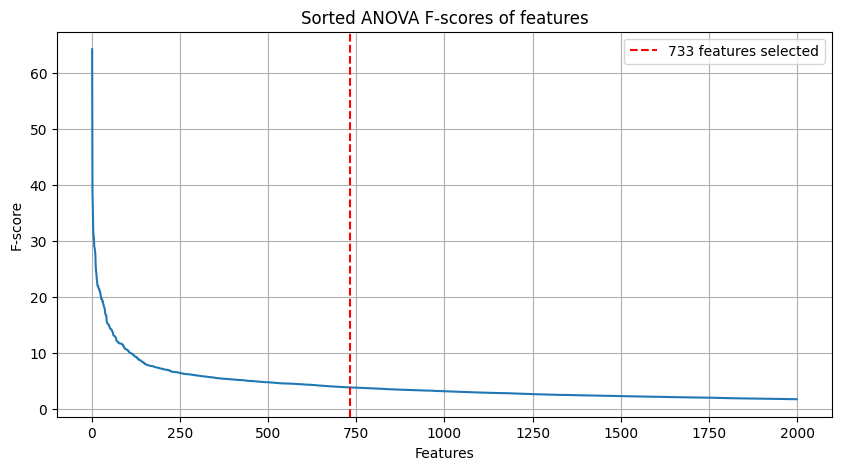

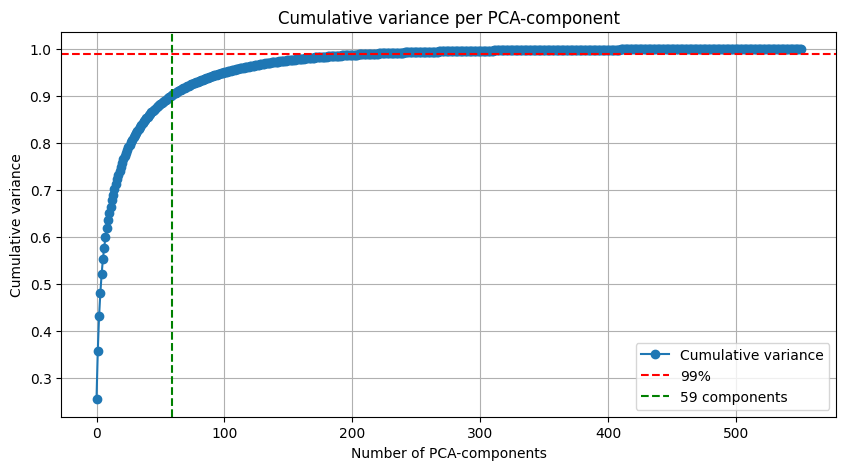

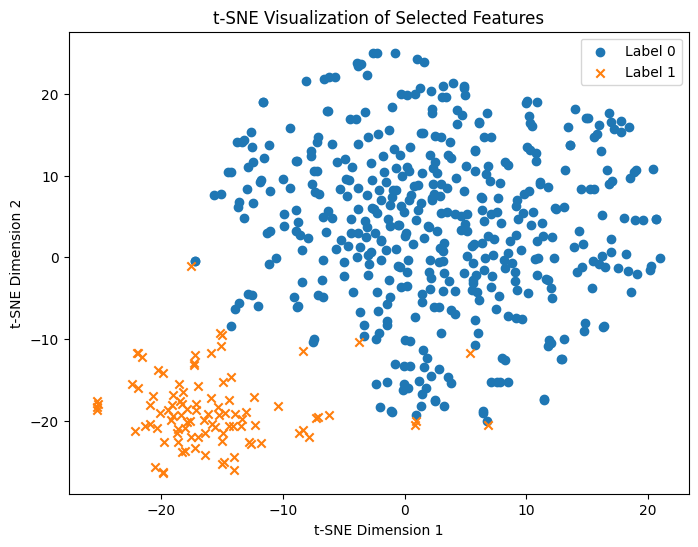

In [16]:
# Visualize f-scores for univariate feature selection
sorted_scores = np.sort(f_scores)[::-1]  # Sort on descending
plt.figure(figsize=(10,5))
plt.plot(sorted_scores[:2000])
plt.axvline(x=k_best, color='r', linestyle='--', label=f'{k_best} features selected')
plt.title('Sorted ANOVA F-scores of features')
plt.xlabel('Features')
plt.ylabel('F-score')
plt.legend()
plt.grid(True)
plt.show()

# Plot variance for PCA
plt.figure(figsize=(10,5))
plt.plot(cumulative_var, marker='o', label='Cumulative variance')
plt.axhline(y=0.99, color='r', linestyle='--', label='99%') # earlier defined 99% variance threshold for PCA
plt.axvline(x=pca_components, color='g', linestyle='--', label=f'{pca_components} components')
plt.title('Cumulative variance per PCA-component')
plt.xlabel('Number of PCA-components')
plt.ylabel('Cumulative variance')
plt.legend()
plt.grid(True)
plt.show()

# Visualize new features with t-SNE
tsne = TSNE(n_components=2, random_state=42) # Reduce to 2 dimensions for plotting
data_tsne = tsne.fit_transform(data_final_selected)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[y_train1 == 0, 0], data_tsne[y_train1 == 0, 1], label='Label 0', marker='o')  # Plot points for label 0
plt.scatter(data_tsne[y_train1 == 1, 0], data_tsne[y_train1 == 1, 1], label='Label 1', marker='x')  # Plot points for label 1
plt.legend()  # Add a legend to identify the labels
plt.title('t-SNE Visualization of Selected Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Performance estimate

mean F1-score on testdata: 0.9787234042553191


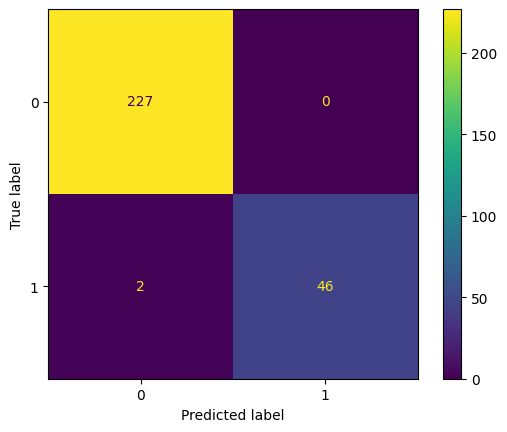

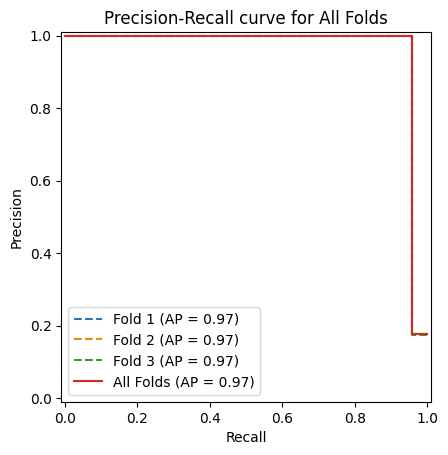

In [17]:
f1_test_mean = np.mean(f1_test)
print(f"mean F1-score on testdata: {f1_test_mean}")

# confusion matrix
metrics.confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test, y_pred_test),
                              display_labels=np.unique(y_test)) # Changed to unique labels in filtered_label_test
disp.plot()
plt.show()

# # Plot Precision-Recall curve

all_precisions = []
all_recalls = []
all_average_precisions = []
fig, ax = plt.subplots()
for i, (precision, recall, average_precision) in enumerate(precision_recall_list):
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_average_precisions.append(average_precision)
    # Plot Precision-Recall curve
    display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
    display.plot(ax=ax, name=f"Fold {i+1}", linestyle='--')  # Plot on the same axes with a label for each fold

display = PrecisionRecallDisplay(precision=np.mean(all_precisions, axis=0), recall=np.mean(all_recalls, axis=0), average_precision=np.mean(all_average_precisions))
display.plot(ax=ax, name=f"All Folds", linestyle='-')  # Plot on the same axes with a label for each fold
plt.title('Precision-Recall curve for All Folds')
plt.show()